# Control analysis across the population 

In [1]:
# Load the tfa model 
from pytfa.io.json import load_json_model
# model_file = 'reduced_model_ETC_core_20240816-155234_continuous.json'
model_file = 'reduced_model_ETC_core_20250228-213124_continuous.json'
tmodel = load_json_model(model_file)
#sol = tmodel.optimize()

2025-03-04 10:28:14,768 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [2]:
# Ploting tool 
import matplotlib.pyplot as plt
# Set arial 16 as the default font
plt.rcParams.update({'font.size': 16 ,}) # 'font.family': 'Arial'})

In [3]:
# Reload and prepare the model
from skimpy.io.yaml import load_yaml_model
from skimpy.utils.tabdict import TabDict

kmodel = load_yaml_model(model_file.replace("_continuous.json", "_kinetic_curated.yml"))
kmodel.repair()

# We calculate control coeffcients with respect
#  to enzyme activity and boundary concentrations
parameter_list = TabDict([(k, p.symbol) for k, p in kmodel.parameters.items() if p.name.startswith('vmax_forward')])
boundary_parameters = TabDict([(c.reactant.name, c.reactant.symbol) for c in kmodel.boundary_conditions.values()])
parameter_list.update(boundary_parameters)

# Compile the jacobian expressions
NCPU = 12
kmodel.prepare()
kmodel.compile_mca(ncpu=NCPU, parameter_list=parameter_list)

In [4]:

# Scaling parameters
CONCENTRATION_SCALING = 1e3 # 1 mol to 1 mmol
TIME_SCALING = 1 # 1min
DENSITY = 1200 # g/L 
GDW_GWW_RATIO = 1.0 # Fluxes are in gWW

# To test how close to zero the dxdt is
flux_scaling_factor = 1e-6 / (GDW_GWW_RATIO / DENSITY) \
                        * CONCENTRATION_SCALING \
                        / TIME_SCALING

In [5]:
# Load TFA samples 
import pandas as pd
#tfa_sample_file = 'reduced_model_ETC_core_20240816-155234_tfa_sampling.csv'
tfa_sample_file = 'reduced_model_ETC_core_20250228-213124_tfa_sampling.csv'
tfa_samples = pd.read_csv(tfa_sample_file)


faraday_const = 23.061 # kcal / mol / mV
RT = tmodel.RT # kcal /mol
delta_psi_scaled = -150/1000 * faraday_const / RT # mV * F / RT 

# Add additional fluxes and concentration to model insulin turnover
# Turnover of inusnlin is about 5 min 

tfa_samples['Insulin_secretion'] = 1/5 / flux_scaling_factor
tfa_samples['Insulin_degradation'] = 1/5 / flux_scaling_factor
tfa_samples['insulin_e'] = 1e-3 

tfa_samples['Stimulation_on'] = 1 / flux_scaling_factor 
tfa_samples['Stimulation_off'] = 1 / flux_scaling_factor
tfa_samples['stim_e'] = 1e-3


# Psuedo data for the membrane potential
tfa_samples['psi_m_c'] = delta_psi_scaled * 1e-3 # be aware of the scaling!!!
tfa_samples['MitoMembranePot'] = -1.0

additional_fluxes = ['Insulin_secretion', 'Insulin_degradation', 'Stimulation_on', 'Stimulation_off', 'MitoMembranePot']
additional_concentrations = ['insulin_e', 'stim_e', 'psi_m_c',]


In [6]:
# Load parameter samples 
from skimpy.core.parameters import load_parameter_population
parameter_population = load_parameter_population(tfa_sample_file.replace(".csv",'_pruned_parameters.hdf5'))

In [7]:
from skimpy.analysis.oracle.load_pytfa_solution import load_fluxes, load_concentrations,\
    load_equilibrium_constants
import numpy as np

flux_controll_coefficients = []
parameter_sample_ids = []

for k in parameter_population._index:

    parameter_values = parameter_population[k]

    i = int(k.split(',')[0]) 
    ref_solution = tfa_samples.loc[i]


    # Load fluxes and concentrations
    fluxes = load_fluxes(ref_solution, tmodel, kmodel,
                            density=DENSITY,
                            ratio_gdw_gww=GDW_GWW_RATIO,
                            concentration_scaling=CONCENTRATION_SCALING,
                            time_scaling=TIME_SCALING,
                            additional_fluxes=additional_fluxes)
    
    concentrations = load_concentrations(ref_solution, tmodel, kmodel,
                                            concentration_scaling=CONCENTRATION_SCALING,
                                            additional_concentrations=additional_concentrations)
    
    this_fc = kmodel.flux_control_fun(fluxes,concentrations,[parameter_values, ])

    # Prune
    medium_control = this_fc.slice_by('sample', 0).loc[['L_LACt2r','GLCt1r', 'HDCAtr', 'BHBt'],['lac_L_e', 'glc_D_e', 'hdca_e', 'bhb_e']]
    diag_is_positive = np.all(np.diag(medium_control.values) >= 0)

    if diag_is_positive:
        flux_controll_coefficients.append(this_fc)
        parameter_sample_ids.append(k)


In [8]:
i, k

(179, '179,9')

In [9]:
print(f"Percent of models selected:{len(parameter_sample_ids) / len( parameter_population._data) * 100:.1f}% ({len(parameter_sample_ids)} models)")

Percent of models selected:98.4% (1933 models)


In [10]:
# Stack the results
from skimpy.utils.tensor import Tensor
import numpy as np
# Concat the data
data = np.concatenate([f._data for f in flux_controll_coefficients], axis=2)
# Conver to tensor 
indexes = flux_controll_coefficients[0].indexes['flux'], flux_controll_coefficients[0].indexes['parameter'], pd.Index(parameter_sample_ids, name='samples')
control_coefficients = Tensor(data, indexes )


In [11]:
from skimpy.utils.general import get_stoichiometry
S = get_stoichiometry(kmodel, kmodel.variables)

In [12]:
import seaborn as sns 
import matplotlib.pyplot as plt 

mean_flux_control = control_coefficients.quantile('samples', 0.5) #.mean('samples') #
mean_flux_control.columns = [i.replace("vmax_forward_", '') for i in mean_flux_control.columns ]

# Make FATP1t operated in reverse to uptake FA
rows = ['GLCt1r',  'L_LACt2r','HDCAtr', 'BHBt','cyt_atp2adp']
# Parameters to exclude
excluded_parameters =  ['ATPS4mi', 'ATPtm','cyt_atp2adp' , 'na1_e','na1_c']
colums = [i for i in mean_flux_control.columns if i not in excluded_parameters]

mean_flux_control = mean_flux_control.loc[rows,colums]



In [13]:
len(tmodel.reactions)

72

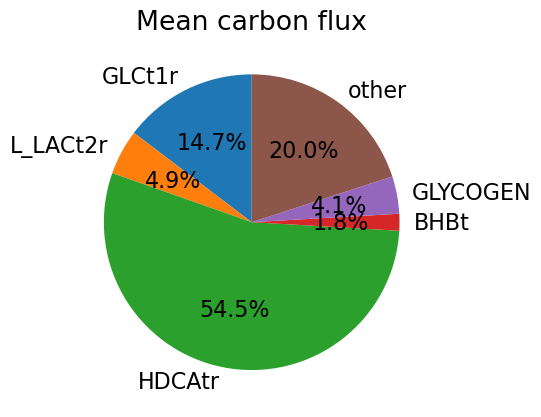

In [14]:
# Change font size to 16 
#plt.rcParams.update({'font.size': 16})

# Scale scale the uptake fluxes by the number of carbons
mean_fluxes = load_fluxes( tfa_samples.mean(), tmodel, kmodel,
                            density=DENSITY,
                            ratio_gdw_gww=GDW_GWW_RATIO,
                            concentration_scaling=1.,
                            time_scaling=TIME_SCALING,
                            additional_fluxes=additional_fluxes).abs()

# Compute glycogen contirbution
mean_fluxes['GLYCOGEN'] = mean_fluxes['glycogen_degradation'] - mean_fluxes['glycogen_synthesis']

carbons = pd.Series({ 'GLCt1r': 6, 'L_LACt2r': 3, 'HDCAtr': 16, 'BHBt': 4,  'GLYCOGEN': 6.0 })

mean_carbon_flux = (mean_fluxes * carbons)[carbons.keys()]

# Add a column that accounts for 20% of the total flux and label it as 'other'
mean_carbon_flux['other'] = mean_carbon_flux.sum() * (1/0.80 - 1)



# A pie chart shoeing the distribution of the mean carbon flux:
fig, ax = plt.subplots()
mean_carbon_flux.plot.pie(ax=ax, subplots=True, figsize=(5,5), autopct='%1.1f%%', startangle=90)
plt.ylabel('')
ax.set_title('Mean carbon flux')

plt.show()

In [15]:
mean_fluxes['glycogen_degradation'] - mean_fluxes['glycogen_synthesis']

0.010000755619103935

In [16]:
mean_fluxes

ACACT1rm           0.006745
ACONTm             0.529380
ADK1               0.049987
AKGDm              0.529380
AKGMALtm           0.080605
                     ...   
r2435              0.049987
Stimulation_on     1.000000
Stimulation_off    1.000000
MitoMembranePot    1.200000
GLYCOGEN           0.010001
Length: 65, dtype: float64

In [17]:
mean_fluxes['GLCt1r']

0.03590728950320114

In [18]:
carbons = pd.Series({ 'GLCt1r': 6, 'L_LACt2r': 3, 'HDCAtr': 16, 'BHBt': 4, 'cyt_atp2adp': 1})[rows]

mean_flux_control_corr = mean_flux_control#.multiply(mean_fluxes, axis=0).multiply(carbons, axis=0)
mean_flux_control_corr.head()

,ACACT1rm,ACONTm,ADK1,AKGDm,AKGMALtm,ASPGLUm,ASPTA,ASPTAm,BDHm,BHBt,...,co2_e,glc_D_e,glycogen_c,h_e,hdca_e,lac_L_e,o2_e,pi_c,pi_m,h_c
flux,,,,,,,,,,,,,,,,,,,,,
GLCt1r,0.000003,8.395598e-05,0.001083,0.001391,3.873380e-06,0.000982,3.414890e-06,0.000047,0.000001,2.939540e-07,...,-0.000409,4.701205e-01,-0.004669,-0.000747,-0.000813,-0.000843,0.000057,-0.004130,NaN,NaN
L_LACt2r,-0.001193,-6.084218e-02,1.911492,0.046465,4.506999e-03,0.979105,3.881578e-03,0.051534,-0.000097,-2.027271e-05,...,-0.158304,-3.344976e-01,-0.544992,1.338353,-0.279263,1.494657,-0.135653,1.804969,-1.455377,0.325293
HDCAtr,-0.006199,-1.092002e-04,0.051423,-0.033577,-2.953148e-04,-0.059675,-2.540822e-04,-0.003187,-0.002948,-4.360327e-04,...,0.018610,-2.230199e-03,-0.005026,-0.061653,0.042067,-0.037268,0.031453,0.674770,-0.302669,0.207743
BHBt,0.287365,5.394744e-02,-0.109371,0.357269,-8.691555e-04,-0.180277,-7.667162e-04,-0.009967,0.133599,1.925345e-02,...,-0.204793,-9.109381e-03,-0.015253,1.034378,-0.416314,-0.112392,0.011225,3.002894,-1.386240,0.930338
cyt_atp2adp,0.000003,7.000106e-07,0.000457,0.000025,1.764592e-07,0.000037,1.481757e-07,0.000002,0.000002,2.272120e-07,...,-0.000013,-3.499192e-07,0.000003,0.000032,-0.000024,0.000019,-0.000006,-0.000382,NaN,-0.000087


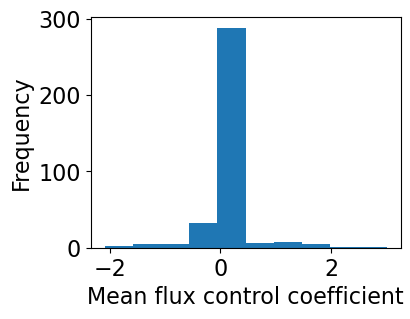

In [19]:
f, ax = plt.subplots(figsize=(4, 3))
plt.hist(mean_flux_control_corr.values.flatten(), bins=10)
plt.xlabel('Mean flux control coefficient')
plt.ylabel('Frequency')
plt.show()

In [20]:
# Find columns with nan values 
nan_columns = mean_flux_control_corr.columns[mean_flux_control_corr.isna().any()]
nan_columns

Index(['CYOOm2i', 'CYOR_u10mi', 'pi_m', 'h_c'], dtype='object')

ValueError: The condensed distance matrix must contain only finite values.

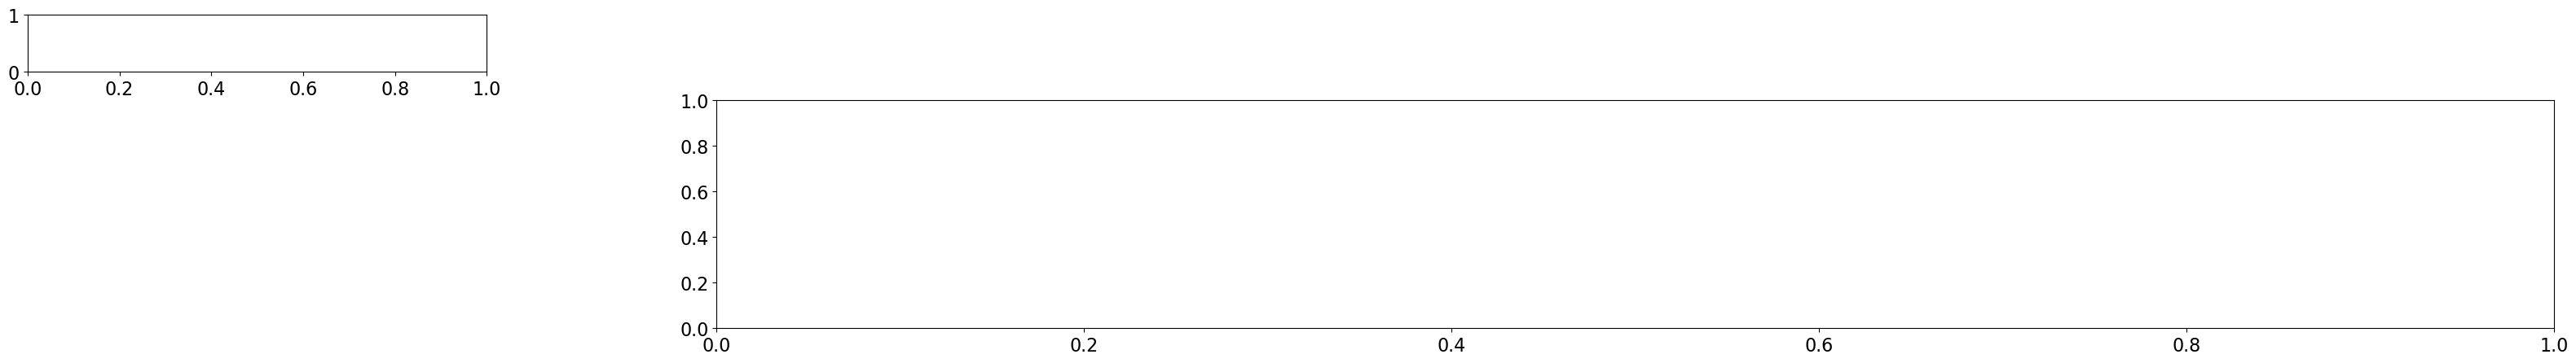

: 

In [21]:

# Plot a cluster map of the flux control coefficients
sns.clustermap(mean_flux_control_corr,row_cluster=True,col_cluster=True, cmap='bwr', center=0, figsize=(40,5), vmin=-1, vmax=1) 
# Change the xtick to have all colm

plt.show()

In [37]:
# Get the parameter set that is closeset to the median flux control coefficients
median_control_coeffcienets = control_coefficients.quantile('samples', 0.5) 

distance_to_median = [((control_coefficients.slice_by('samples', i).loc[rows] - median_control_coeffcienets.loc[rows])**2).values.sum() for i in control_coefficients.indexes['samples']]

closest_to_median = control_coefficients.indexes['samples'][np.argmin(distance_to_median)]

print(f'Closest to median: {closest_to_median} with distance {np.min(distance_to_median)} (mean distance {np.mean(distance_to_median)})')


Closest to median: 378,0 with distance nan (mean distance nan)


In [38]:
#closest_to_median =  '103,5'

/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

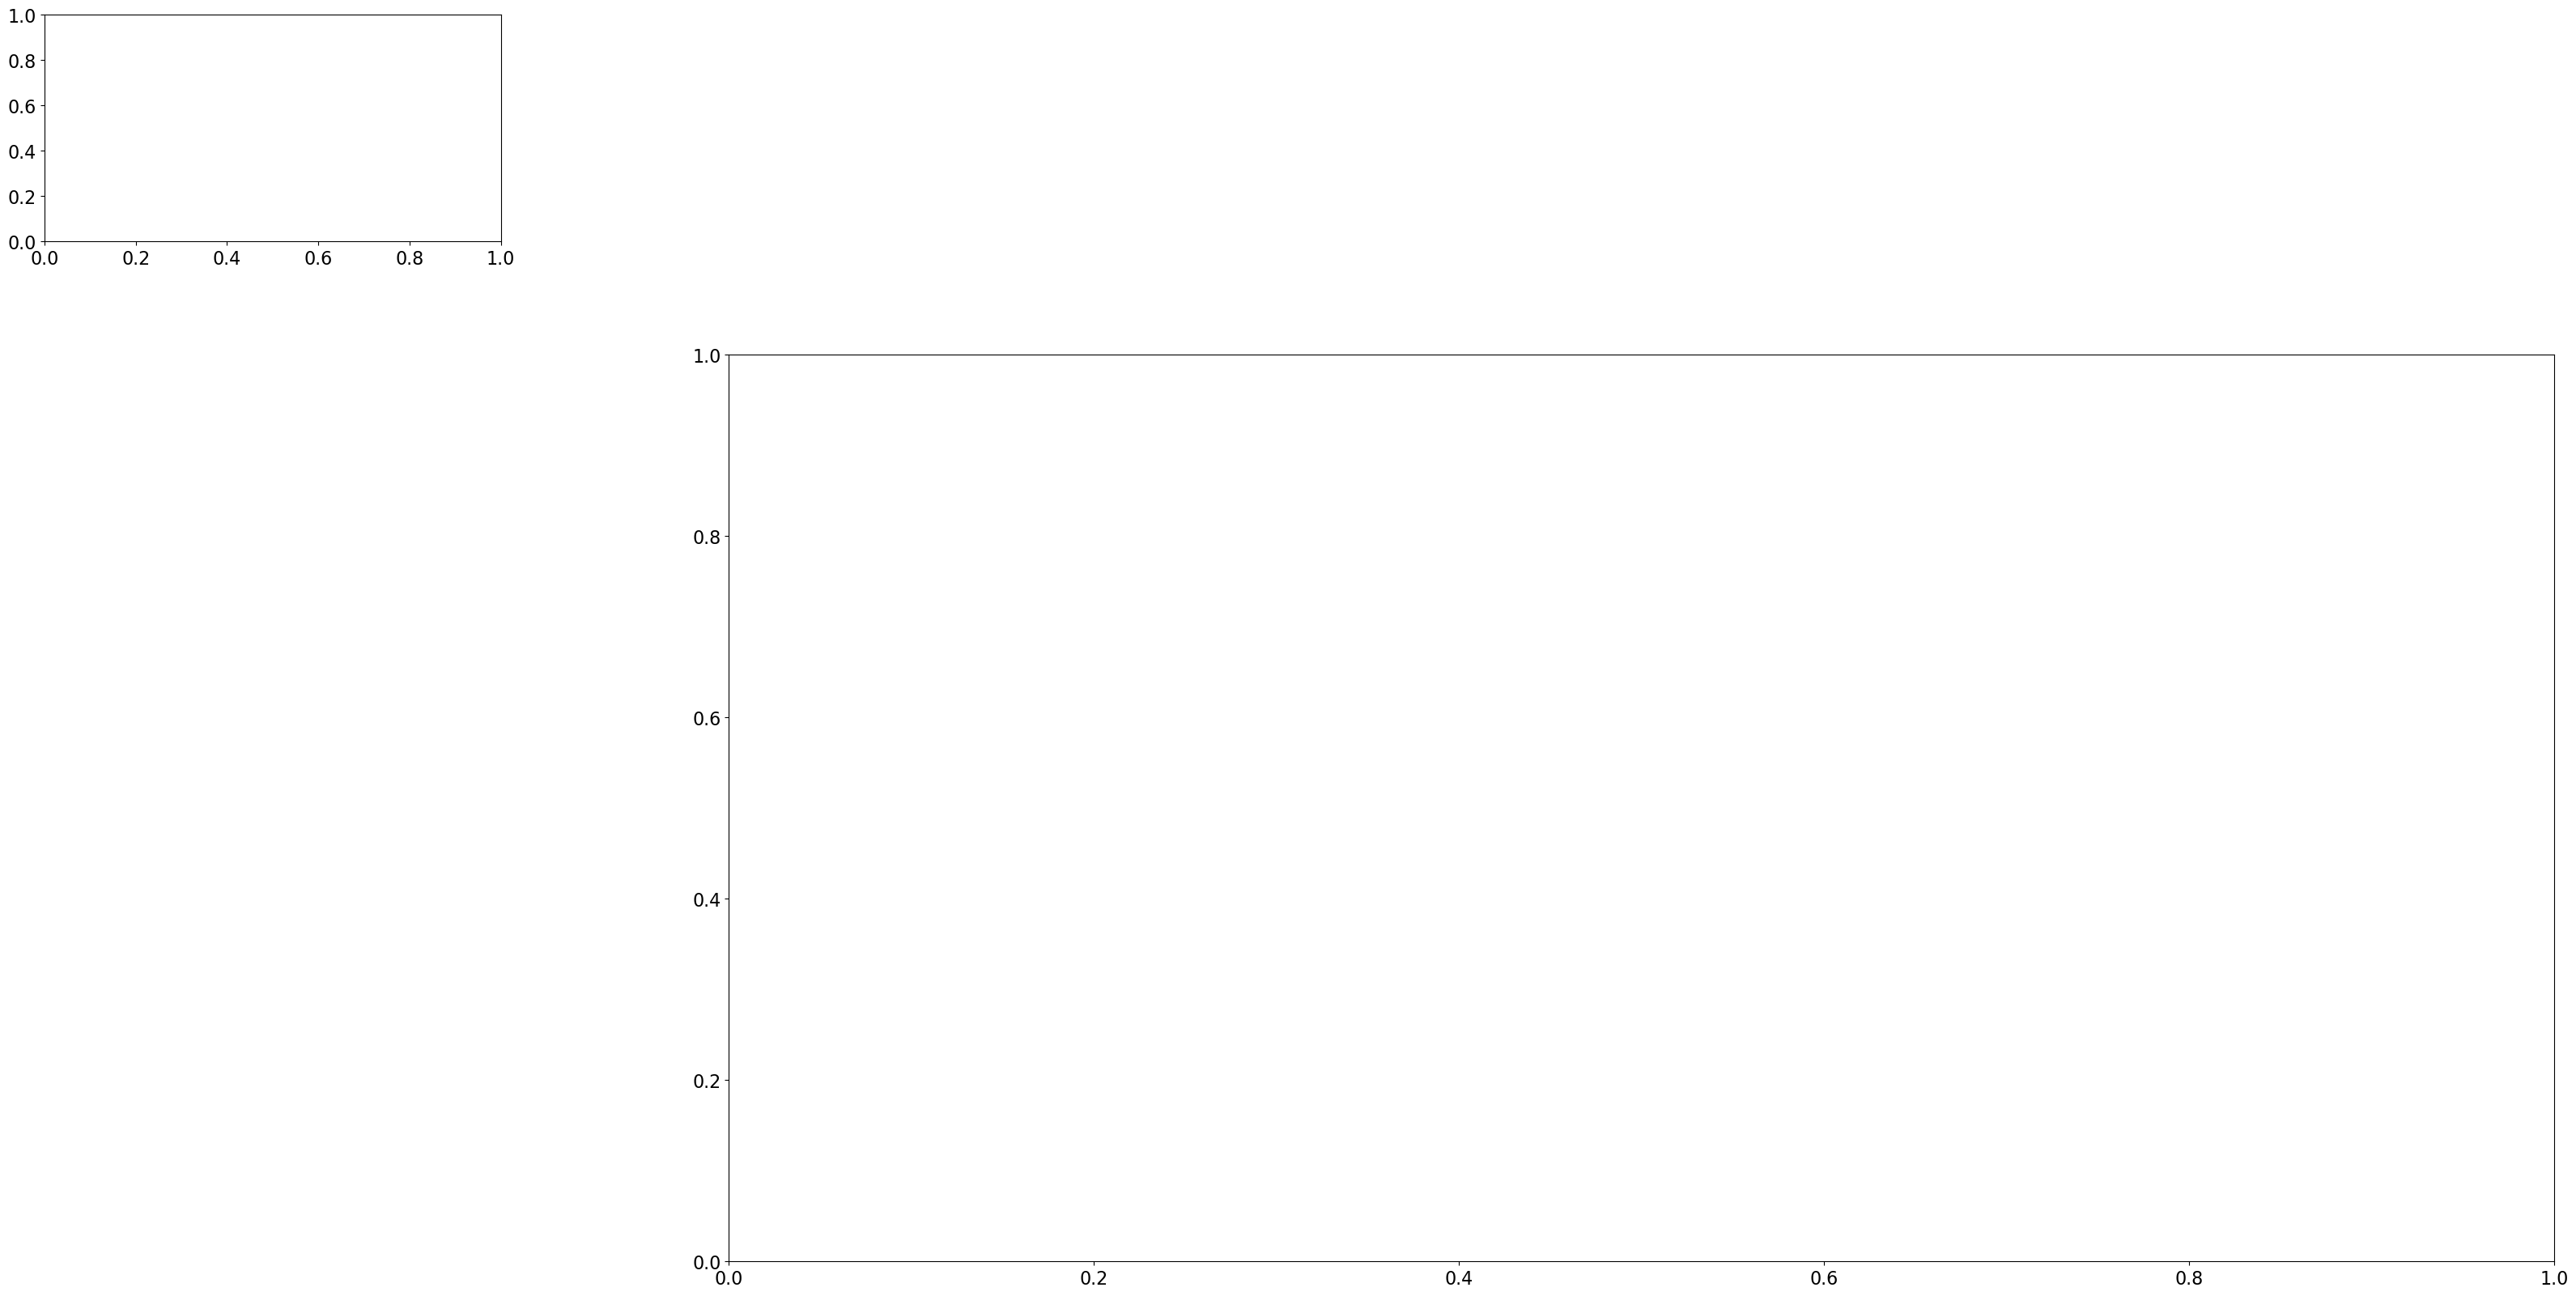

In [39]:
# Check for correlations between the coffecients 
ve_cc = control_coefficients.slice_by('flux','cyt_atp2adp').T

# Drop na 

# Plot cluster map of correlation 
sns.clustermap(ve_cc, cmap='bwr', center=0, figsize=(40,20))

In [ ]:
ve_cc

parameter,vmax_forward_ACACT1rm,vmax_forward_ACONTm,vmax_forward_ADK1,vmax_forward_AKGDm,vmax_forward_AKGMALtm,vmax_forward_ASPGLUm,vmax_forward_ASPTA,vmax_forward_ASPTAm,vmax_forward_ATPS4mi,vmax_forward_ATPtm,...,co2_e,glc_D_e,glycogen_c,h_e,hdca_e,lac_L_e,o2_e,pi_c,pi_m,h_c
samples,,,,,,,,,,,,,,,,,,,,,
"378,0",0.000010,1.920134e-06,0.000557,0.000047,4.259994e-08,0.000077,3.870536e-08,0.000007,0.000135,0.000460,...,-0.000022,-2.811039e-06,-5.628653e-07,0.000035,-0.000014,0.000008,-0.000016,-0.000064,0.000073,0.000059
"378,2",0.000048,6.176130e-06,0.002450,0.000077,1.644209e-06,0.000161,1.488654e-06,0.000035,0.000456,0.000566,...,-0.000111,2.334172e-06,2.079234e-05,0.000220,-0.000103,0.000109,-0.000039,-0.001148,0.000854,-0.003117
"378,4",0.000042,1.587589e-05,0.002066,0.000160,1.371074e-07,0.000316,1.262240e-07,0.000023,0.000482,0.002125,...,-0.000108,-2.890356e-05,-2.909821e-05,0.000156,-0.000055,0.000034,0.000109,0.000356,0.000103,-0.005463
"378,6",0.000013,-7.056350e-06,0.000611,-0.000029,4.691224e-07,0.000031,4.206371e-07,0.000007,0.000282,0.000614,...,0.000014,-3.835757e-07,4.986297e-06,0.000057,-0.000032,0.000021,-0.000063,-0.000528,0.000390,0.000292
"378,8",0.000023,-6.138188e-06,0.001224,0.000119,6.413535e-08,0.000167,5.832831e-08,0.000026,0.000425,0.000921,...,-0.000013,-7.430651e-06,-6.197918e-06,0.000060,-0.000112,0.000006,-0.000018,0.000280,0.000168,0.001214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"837,1",0.000027,2.079039e-06,0.001962,0.000082,1.286629e-06,0.000069,9.746308e-07,0.000011,0.000234,0.000834,...,-0.000035,4.251952e-06,1.594428e-05,0.000134,-0.000086,0.000062,-0.000132,0.000452,-0.000030,0.000256
"837,2",0.000029,8.211901e-06,0.001910,0.000106,7.269882e-07,0.000129,5.589754e-07,0.000018,0.000814,0.001976,...,-0.000064,2.930868e-06,2.571776e-05,0.000108,-0.000068,0.000035,0.000009,-0.002261,0.001381,-0.002253
"837,3",0.000011,-1.363544e-05,0.000646,-0.000135,1.317433e-07,0.000042,1.018118e-07,0.000004,0.000676,0.001366,...,0.000054,2.264538e-06,7.742033e-06,0.000038,-0.000022,0.000011,-0.000016,0.000348,-0.000133,0.018343


In [25]:
ve_cc

parameter,vmax_forward_ACACT1rm,vmax_forward_ACONTm,vmax_forward_ADK1,vmax_forward_AKGDm,vmax_forward_AKGMALtm,vmax_forward_ASPGLUm,vmax_forward_ASPTA,vmax_forward_ASPTAm,vmax_forward_ATPS4mi,vmax_forward_ATPtm,...,co2_e,glc_D_e,glycogen_c,h_e,hdca_e,lac_L_e,o2_e,pi_c,pi_m,h_c
samples,,,,,,,,,,,,,,,,,,,,,
"378,0",0.000010,1.920134e-06,0.000557,0.000047,4.259994e-08,0.000077,3.870536e-08,0.000007,0.000135,0.000460,...,-0.000022,-2.811039e-06,-5.628653e-07,0.000035,-0.000014,0.000008,-0.000016,-0.000064,0.000073,0.000059
"378,2",0.000048,6.176130e-06,0.002450,0.000077,1.644209e-06,0.000161,1.488654e-06,0.000035,0.000456,0.000566,...,-0.000111,2.334172e-06,2.079234e-05,0.000220,-0.000103,0.000109,-0.000039,-0.001148,0.000854,-0.003117
"378,4",0.000042,1.587589e-05,0.002066,0.000160,1.371074e-07,0.000316,1.262240e-07,0.000023,0.000482,0.002125,...,-0.000108,-2.890356e-05,-2.909821e-05,0.000156,-0.000055,0.000034,0.000109,0.000356,0.000103,-0.005463
"378,6",0.000013,-7.056350e-06,0.000611,-0.000029,4.691224e-07,0.000031,4.206371e-07,0.000007,0.000282,0.000614,...,0.000014,-3.835757e-07,4.986297e-06,0.000057,-0.000032,0.000021,-0.000063,-0.000528,0.000390,0.000292
"378,8",0.000023,-6.138188e-06,0.001224,0.000119,6.413535e-08,0.000167,5.832831e-08,0.000026,0.000425,0.000921,...,-0.000013,-7.430651e-06,-6.197918e-06,0.000060,-0.000112,0.000006,-0.000018,0.000280,0.000168,0.001214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"837,1",0.000027,2.079039e-06,0.001962,0.000082,1.286629e-06,0.000069,9.746308e-07,0.000011,0.000234,0.000834,...,-0.000035,4.251952e-06,1.594428e-05,0.000134,-0.000086,0.000062,-0.000132,0.000452,-0.000030,0.000256
"837,2",0.000029,8.211901e-06,0.001910,0.000106,7.269882e-07,0.000129,5.589754e-07,0.000018,0.000814,0.001976,...,-0.000064,2.930868e-06,2.571776e-05,0.000108,-0.000068,0.000035,0.000009,-0.002261,0.001381,-0.002253
"837,3",0.000011,-1.363544e-05,0.000646,-0.000135,1.317433e-07,0.000042,1.018118e-07,0.000004,0.000676,0.001366,...,0.000054,2.264538e-06,7.742033e-06,0.000038,-0.000022,0.000011,-0.000016,0.000348,-0.000133,0.018343


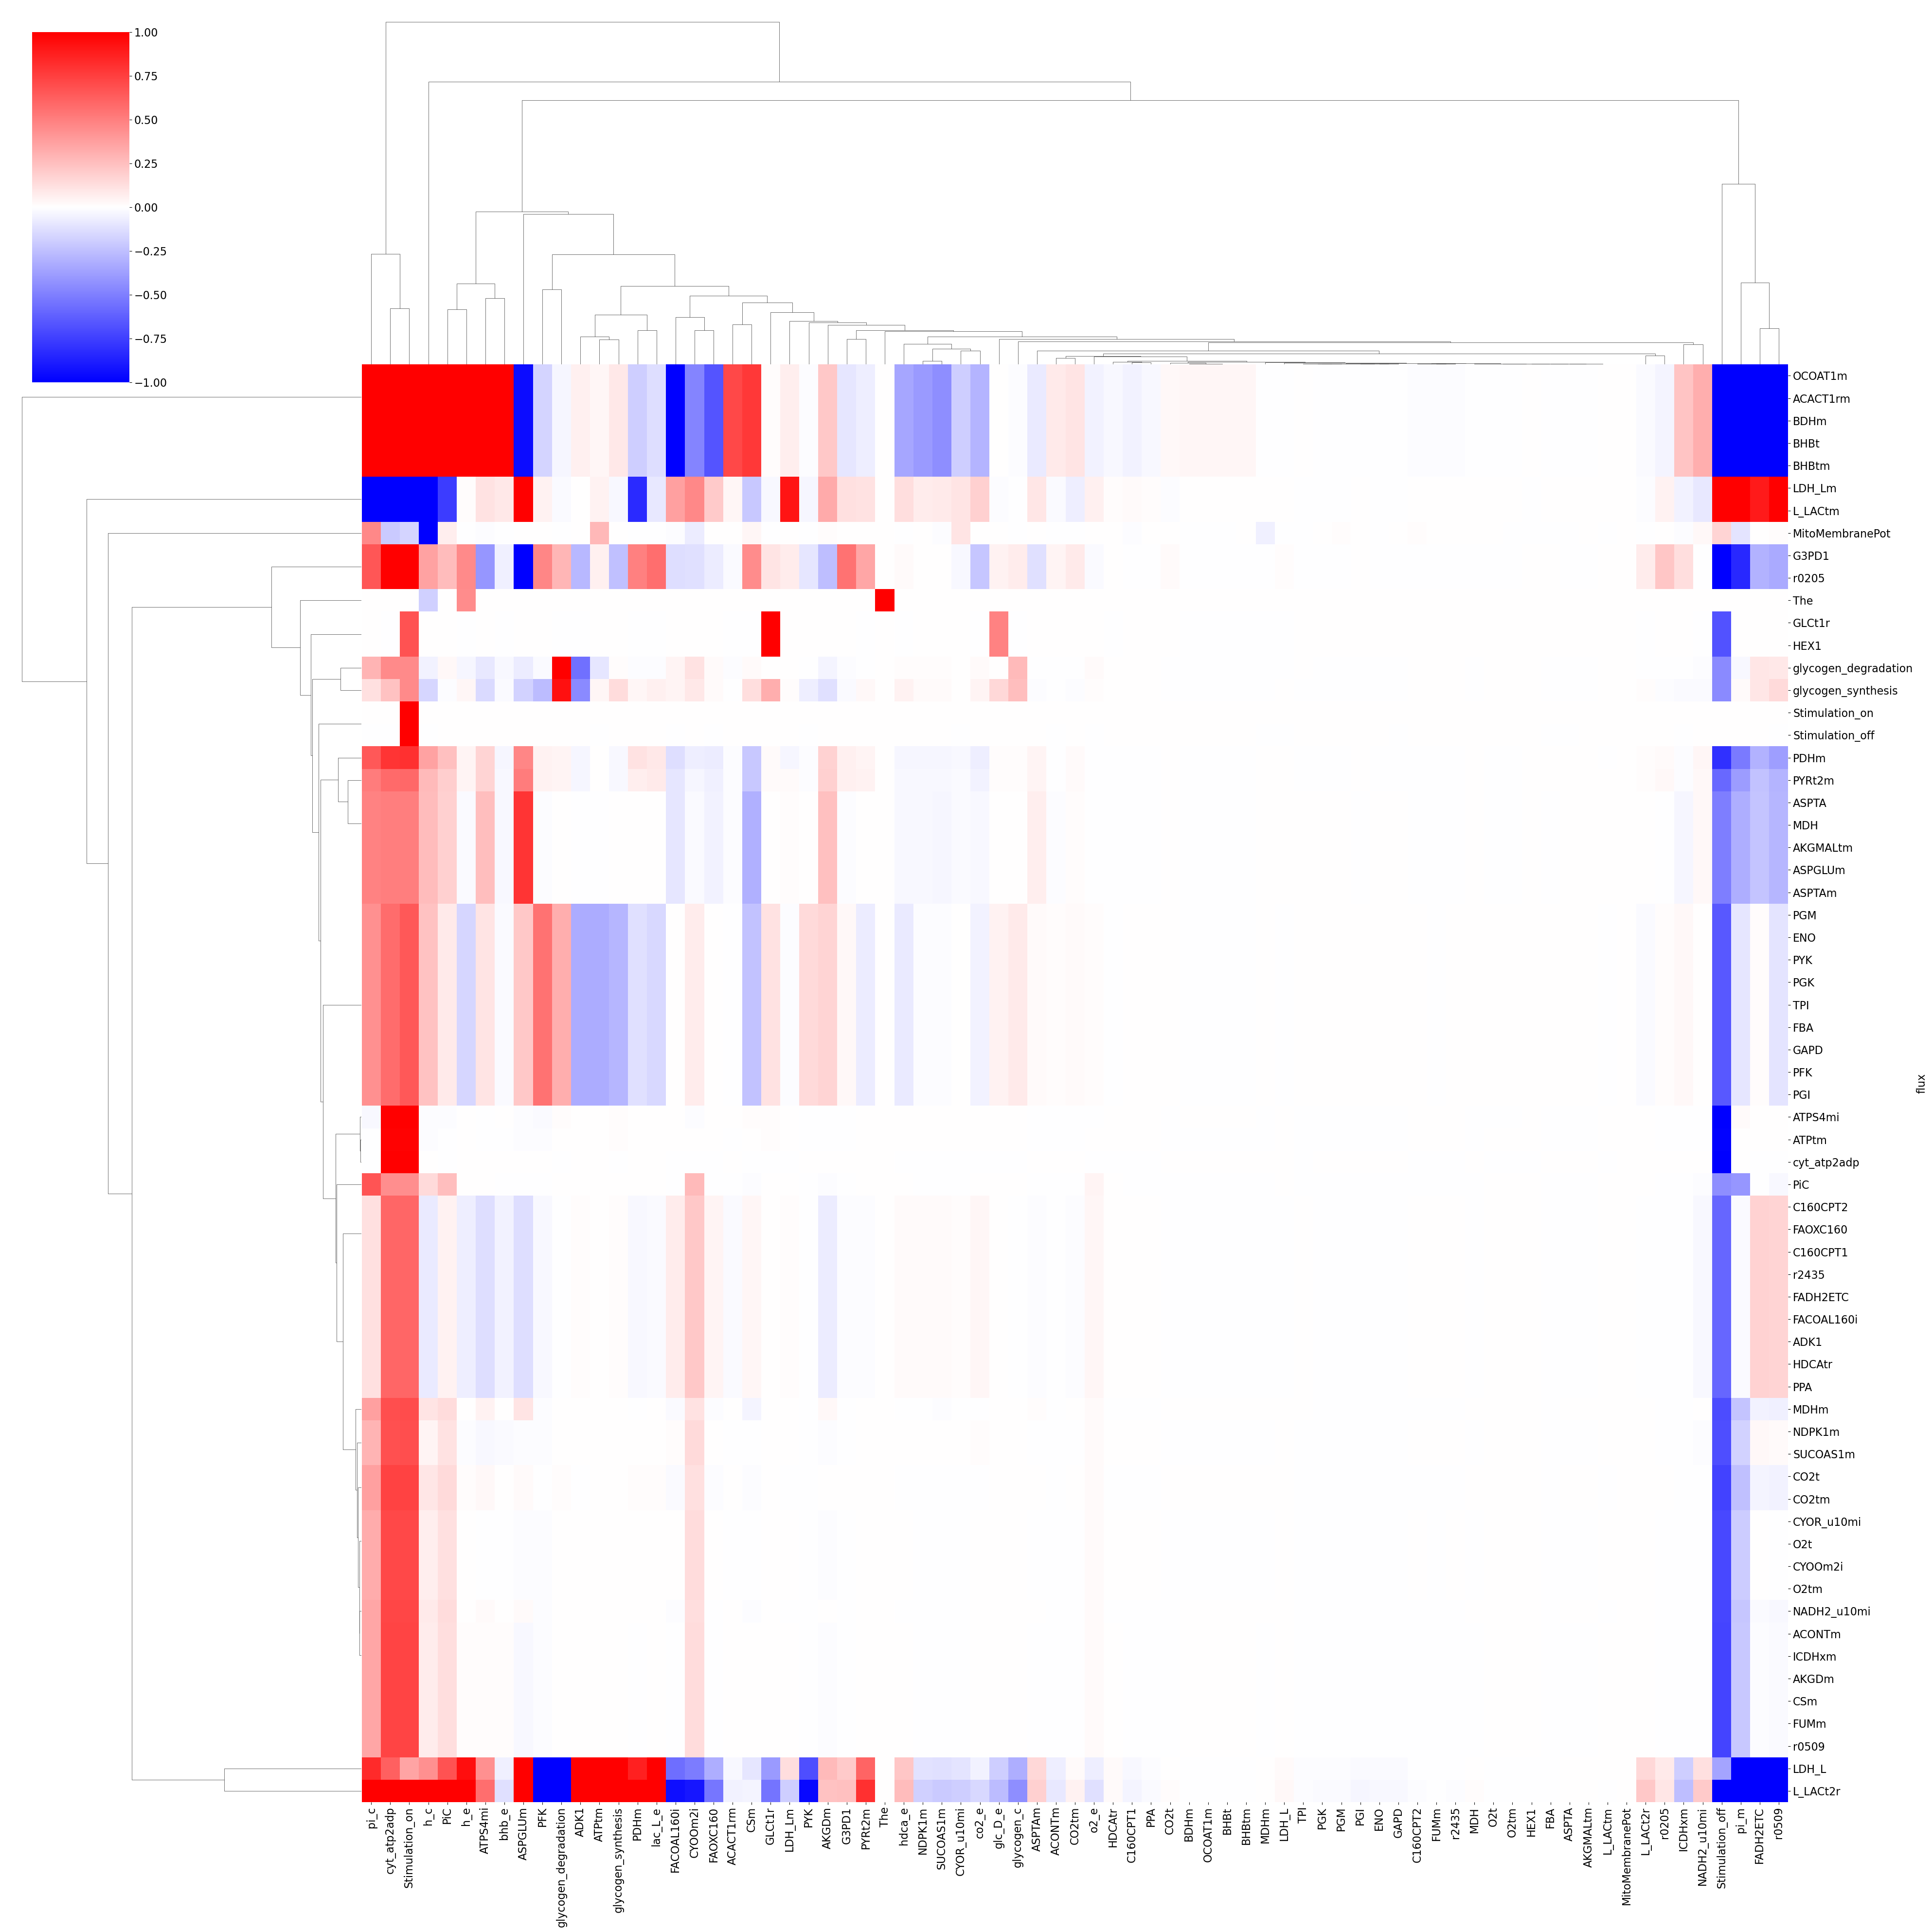

In [ ]:
CC = control_coefficients.slice_by('samples',closest_to_median)
CC.columns = [i.replace("vmax_forward_", '') for i in CC.columns ]
# Plot a cluster map of the flux control coefficients
sns.clustermap(CC.loc[:,:],row_cluster=True,col_cluster=True, cmap='bwr', center=0, figsize=(40,40), vmin=-1.0, vmax=1.0)    
# Change the xtick to have all colm
plt.show()

NameError: name 'CC' is not defined

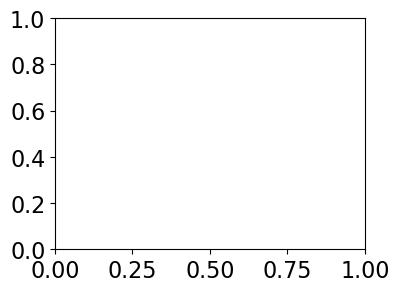

In [40]:
# Make a heat map only for concentration of the carbon sources 
colums = [ 'glc_D_e', 'lac_L_e','bhb_e','hdca_e', 'cyt_atp2adp']
rows = ['GLCt1r',  'L_LACt2r','BHBt', 'HDCAtr','cyt_atp2adp']

f, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(CC.loc[rows,colums] , cmap='bwr', center=0, vmin=-1, vmax=1, )    

# Rename yticks and columns
ax.set_yticklabels(['Glucose uptake', 'Lactate uptake', '3HB uptake', 'Fatty-acids uptake', 'Energy production'])
ax.set_xticklabels(['Glucose', 'Lactate', '3HB', 'Fatty-acids', 'Energy demand'], rotation=45, ha='right')

plt.ylabel('')
plt.xlabel('')
plt.show()


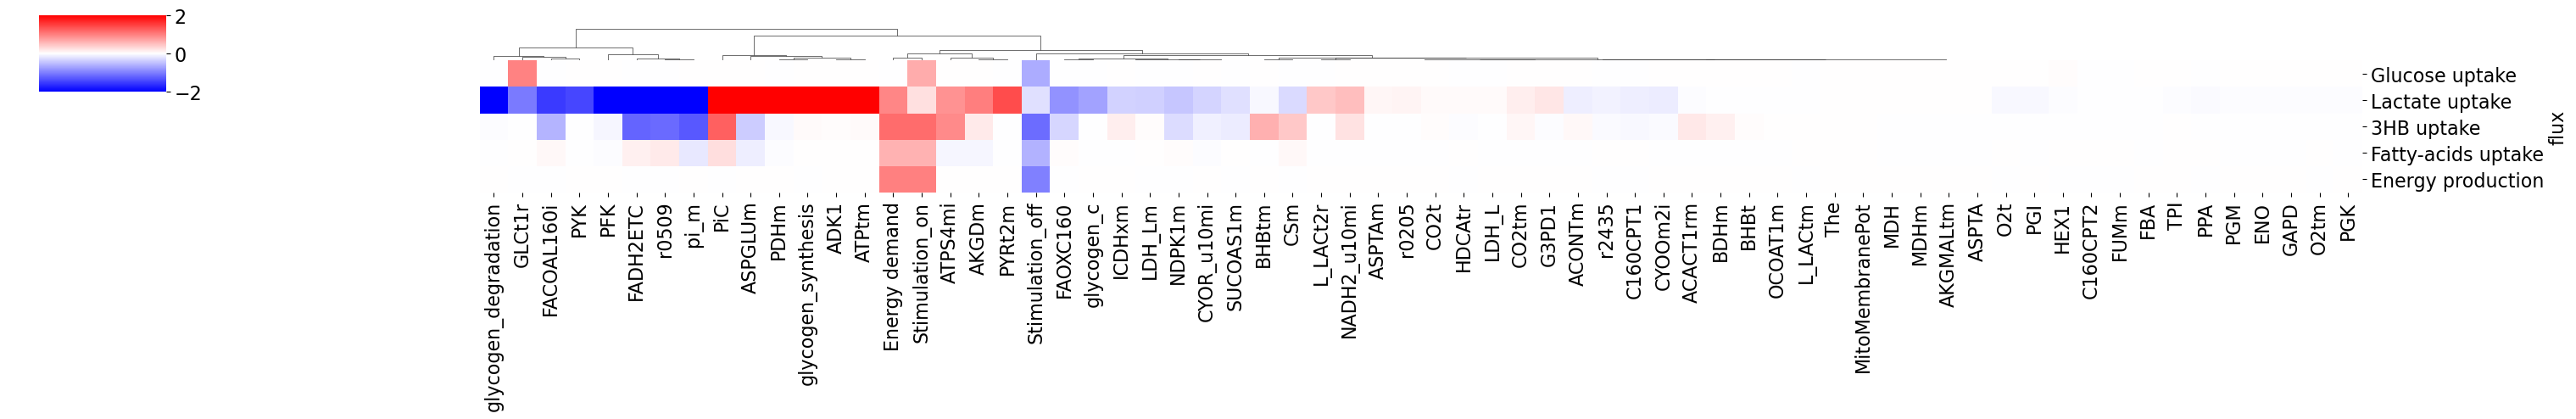

In [41]:
# Cluster enzyme activity control coefficients

CC = control_coefficients.slice_by('samples',closest_to_median)
CC.columns = [i.replace("vmax_forward_", '') for i in CC.columns ]

excluded_parameters = ['NAt3_1','na1_e','na1_c','k_e','k_c', 'h_e','co2_e','o2_e','pi_e','pi_c','h_c'] + [ 'glc_D_e', 'lac_L_e','bhb_e','hdca_e',]
colums = [i for i in CC.columns if i not in excluded_parameters]

# Color by subsystem 
#subsystems_dict = {r.id:r.subsystem for r in tmodel.reactions }
#subsystems = pd.Series([subsystems_dict[c] for c in colums ])
#lut = dict(zip(subsystems.unique(),  ))
#col_colors = subsystems.map(lut)


# Plot a cluster map of the flux control coefficients
ax =sns.clustermap(CC.loc[rows,colums],row_cluster=False,col_cluster=True, cmap='bwr', center=0, metric='euclidean',method='ward',
                   figsize=(30,5) , vmin=-2.0, vmax=2.0, )# col_colors=col_colors)    


# Change y ticks to have the correct names
ax.ax_heatmap.set_yticklabels(['Glucose uptake', 'Lactate uptake', '3HB uptake', 'Fatty-acids uptake', 'Energy production'])
# Change cyt_atp2adp to 'Energy production' in the xticks leave the rest
xticks = ax.ax_heatmap.get_xticklabels()
xticks = [i.get_text() if i.get_text() != 'cyt_atp2adp' else 'Energy demand' for i in xticks]
ax.ax_heatmap.set_xticklabels(xticks, rotation=90, ha='center')

plt.savefig('./output/rep_flux_control_coefficients.pdf')
plt.show()


In [42]:
# Compile ODEs 
kmodel.compile_ode(ncpu=NCPU)

In [43]:
thermo_index = int(closest_to_median.split(',')[0])
thermo_sample = tfa_samples.loc[thermo_index]

concentrations = load_concentrations(thermo_sample, tmodel, kmodel, 
                                     concentration_scaling=CONCENTRATION_SCALING,

                                          additional_concentrations=additional_concentrations)  

for k in kmodel.initial_conditions:
        kmodel.initial_conditions[k] = concentrations[k]


In [44]:
# # Test steady state
# sol = kmodel.solve_ode(np.linspace(0, 10, 1000), solver_type='cvode')
# #sol.concentrations.plot()


In [45]:
# Compute fluxes as a function of time 
from skimpy.analysis.ode.utils import make_flux_fun
from skimpy.utils.namespace import QSSA

flux_fun = make_flux_fun(kmodel, QSSA)

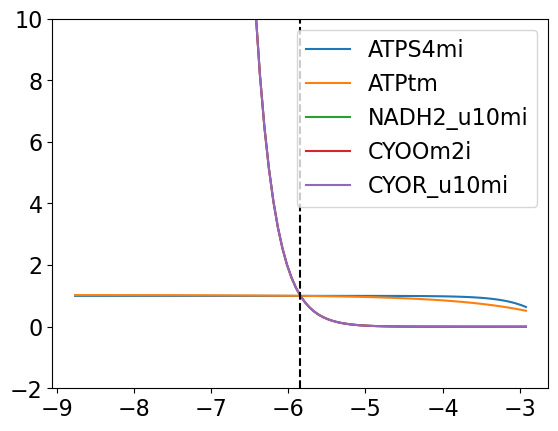

In [ ]:
concentrations['psi_m_c'] = delta_psi_scaled
a = flux_fun( concentrations, parameter_values)

res = []

change = np.linspace(0.5 , 1.5, 101)
for r in change:
    concentrations['psi_m_c'] = delta_psi_scaled * r
    b = flux_fun( concentrations, parameter_values)
    res.append(b)

res =pd.DataFrame(res)

# Plot fluxes of ATP synthase as a function of membrane potential
f, ax = plt.subplots()
plt.plot(change * delta_psi_scaled, res['ATPS4mi']/a['ATPS4mi'], label='ATPS4mi')
plt.plot(change * delta_psi_scaled, res['ATPtm']/a['ATPtm'], label='ATPtm')
plt.plot(change * delta_psi_scaled, res['NADH2_u10mi']/a['NADH2_u10mi'], label='NADH2_u10mi')
plt.plot(change * delta_psi_scaled, res['CYOOm2i']/a['CYOOm2i'], label='CYOOm2i')
plt.plot(change * delta_psi_scaled, res['CYOR_u10mi']/a['CYOR_u10mi'], label='CYOR_u10mi')

plt.ylim(-2,10.0)

# Put vertical line at the median membrane potential
plt.axvline(x=delta_psi_scaled, color='k', linestyle='--')


plt.legend()



In [48]:
thermo_sample['DGo_ATPS4mi'] , thermo_sample['DGo_ATPtm'] , thermo_sample['DGo_NADH2_u10mi'] , thermo_sample['DGo_CYOOm2i'] , thermo_sample['DGo_CYOR_u10mi']

(-6.391679535970995,
 -3.358416819999972,
 -4.1452623393328265,
 -10.34745839294747,
 5.818698856011571)

In [49]:
# Init pretty plotting stuff

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 16, }) #'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 5, 'capthick': 2, 'elinewidth': 2, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['lightsteelblue', 'steelblue']

# Colors to highlight metabolites
# Glucose, lactate, 3HB, Fatty acids
colors_met = ['firebrick', 'lightcoral', 'wheat', 'gold']

# Greys 
colors_grey = ['lightgrey', 'darkgrey', 'dimgrey']

In [50]:
# Scale scale the uptake fluxes by the number of carbons
tfa_idx = int(closest_to_median.split(',')[0])
mean_fluxes = load_fluxes( tfa_samples.loc[tfa_idx,:], tmodel, kmodel,
                            density=DENSITY,
                            ratio_gdw_gww=GDW_GWW_RATIO,
                            concentration_scaling=1.,
                            time_scaling=TIME_SCALING, 
                            additional_fluxes=additional_fluxes)

mean_concentrations = load_concentrations(tfa_samples.loc[tfa_idx,:], tmodel, kmodel,
                                            concentration_scaling=CONCENTRATION_SCALING,
                                            additional_concentrations=additional_concentrations)

In [51]:
from skimpy.core.parameters import ParameterValues

UPTAKES_IN_CARBON = pd.Series({'GLCt1r':6, 'L_LACt2r':3,  'BHBt':4  ,'HDCAtr':16,}, dtype=float)

# units -> nmoles/min/gDW
# Scale to umol/min using a 25g Std mouse 
SCALE = 25/1000

# Compute the fluxes for a perturbation in the uptake of a carbon source
def compute_uptake_perturbation(variable, fold, kmodel=kmodel, parmeters=parameter_population[closest_to_median],
                                time = np.logspace(-6, 3, 1000)-1e-6, solver_type='cvode', carbons_only=True, steady_state=True,
                                parameter_perturbation=dict(), initial_concentrations=mean_concentrations):
    # kmodel -> is initiatlized and compiled above 
    # Get the initial value
    kmodel.parameters = parmeters

    p0 = kmodel.parameters[variable].value
    kmodel.parameters[variable].value = p0 * fold

    # Set the initial concentrations if any
    if initial_concentrations is not None:
        for k, v in kmodel.initial_conditions.items():
            kmodel.initial_conditions[k] = v

    # Additional perturbations in fold changes
    for k, v in parameter_perturbation.items():
        p0 = kmodel.parameters[k].value
        kmodel.parameters[k].value = p0 * v


    # Solve the ODEs
    sol = kmodel.solve_ode(time, solver_type=solver_type ,  max_steps=1e9,)

    # Get parameters value set 
    parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
    parameter_values = ParameterValues(parameter_values, kmodel)

    steady_state_fluxes = pd.Series(flux_fun(sol.concentrations.iloc[-1], parameters=parameter_values), 
                                    index=kmodel.reactions.keys())

    if carbons_only and steady_state:
        result = steady_state_fluxes.loc[UPTAKES_IN_CARBON.keys()].multiply(UPTAKES_IN_CARBON, axis=0) * SCALE
    elif steady_state:
        result = steady_state_fluxes * SCALE
    else:
        result = pd.DataFrame([flux_fun(sol.concentrations.iloc[i], parameters=parameter_values) for i in range(len(time))], columns=kmodel.reactions.keys(), index=sol.time)
        # Concat fluxes and concentrations
        time_concentrations = sol.concentrations.copy()
        time_concentrations.index = sol.time
        result = pd.concat([result, time_concentrations], axis=1)

 
    return result

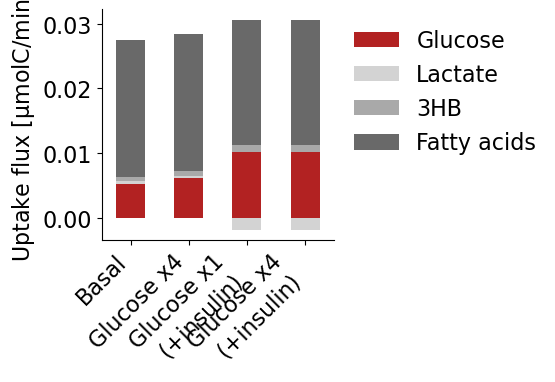

In [ ]:
# Glucose infusion +/- inuslin effect 
non_pertubative = compute_uptake_perturbation('glc_D_e', 1)
pertubative = compute_uptake_perturbation('glc_D_e', 1.5)


insulin_effect = {'vmax_forward_GLCt1r':5,
                  'hdca_e': 0.25,
                  'lac_L_e': 1.0,
                  'bhb_e': 1.0,
                  'vmax_forward_PFK':5.0, 
                  }


non_pertubative_ins = compute_uptake_perturbation('glc_D_e', 1, parameter_perturbation=insulin_effect)
pertubative_ins = compute_uptake_perturbation('glc_D_e', 1.5, parameter_perturbation=insulin_effect)


df = pd.DataFrame({'Basal':non_pertubative, 'Glucose x4':pertubative, 
                   'Glucose x1\n(+insulin)':non_pertubative_ins, 'Glucose x4\n(+insulin)':pertubative_ins}).T

df.columns = ['Glucose', 'Lactate', '3HB', 'Fatty acids']
colors = [colors_met[0],] + colors_grey

f, ax = plt.subplots(figsize=(3,3)) 
df.plot(kind='bar', stacked=True, color=colors, ax=ax, )
plt.xticks(rotation=45, ha='right') 
plt.ylabel('Uptake flux [$\mathrm{\mu}$molC/min]')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
sns.despine()

plt.savefig('./output/glucose_perturbation.svg')
plt.show()

In [53]:
insulin_effect = {'vmax_forward_GLCt1r':5.0,
                  'hdca_e': 0.2,
                  'lac_L_e': 1.0,
                  'bhb_e': 1,
                  'vmax_forward_PFK':5.0, 
                  }

non_pertubative_ins1 = compute_uptake_perturbation('glc_D_e', 1, parameter_perturbation=insulin_effect, carbons_only=False)


insulin_effect = {'vmax_forward_GLCt1r':5.0,
                  'hdca_e': 0.2,
                  'lac_L_e': 5.0,
                  'bhb_e': 1,
                  'vmax_forward_PFK':5.0, 
                  }

non_pertubative_ins2 = compute_uptake_perturbation('glc_D_e', 1, parameter_perturbation=insulin_effect, carbons_only=False)


rel = non_pertubative_ins2 / non_pertubative_ins1
rel.to_csv('./lactate_clamp_effect.csv')

In [54]:
rel

ACACT1rm           1.002467
ACONTm             1.008234
ADK1               1.001079
AKGDm              1.008232
AKGMALtm           1.005546
                     ...   
r0509              1.008232
r2435              1.001078
Stimulation_on     1.000000
Stimulation_off    1.000000
MitoMembranePot   -2.178696
Length: 64, dtype: float64

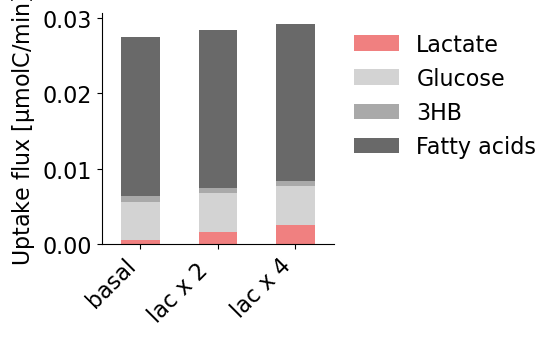

In [ ]:
# Lactate infusion +/- PDH inhibition 
non_pertubative = compute_uptake_perturbation('lac_L_e', 1)
pertubative_2 = compute_uptake_perturbation('lac_L_e', 2.5)
pertubative_4 = compute_uptake_perturbation('lac_L_e', 5)


df = pd.DataFrame({'basal':non_pertubative, 'lac x 2 ':pertubative_2,'lac x 4':pertubative_4, }).T
# Sort index
df = df[['L_LACt2r',  'GLCt1r', 'BHBt', 'HDCAtr']]
df.columns = ['Lactate', 'Glucose',  '3HB', 'Fatty acids']
colors = [colors_met[1],] + colors_grey

f, ax = plt.subplots(figsize=(3,3)) 
df.plot(kind='bar', stacked=True, color=colors, ax=ax, )
plt.xticks(rotation=45, ha='right') 
plt.ylabel('Uptake flux [$\mathrm{\mu}$molC/min]')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
sns.despine()

plt.savefig('./output/lactate_perturbation.svg')
plt.show()

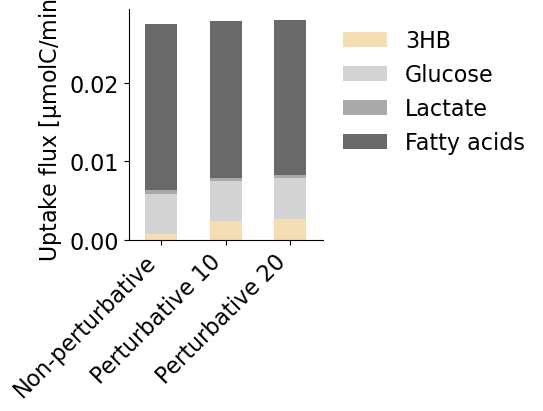

In [56]:
# 3HB infusion 
non_pertubative = compute_uptake_perturbation('bhb_e', 1)
pertubative_1 = compute_uptake_perturbation('bhb_e',10)
pertubative_2 = compute_uptake_perturbation('bhb_e',20)


df = pd.DataFrame({'Non-perturbative':non_pertubative, 'Perturbative 10':pertubative_1, 
                   'Perturbative 20':pertubative_2}).T
# Sort index
df = df[[  'BHBt','GLCt1r','L_LACt2r', 'HDCAtr']]
df.columns = ['3HB', 'Glucose',  'Lactate', 'Fatty acids']
colors = [colors_met[2],] + colors_grey

f, ax = plt.subplots(figsize=(2.5,3)) 
df.plot(kind='bar', stacked=True, color=colors, ax=ax, )
plt.xticks(rotation=45, ha='right') 
plt.ylabel('Uptake flux [$\mathrm{\mu}$molC/min]')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
sns.despine()

plt.savefig('./output/3hb_perturbation.svg')
plt.show()


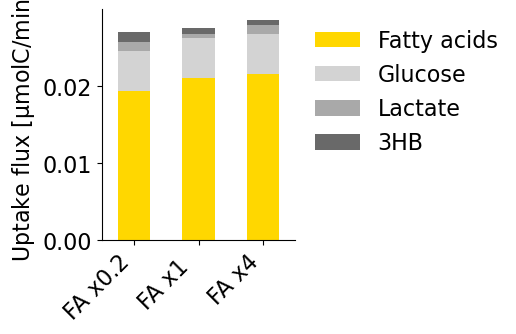

In [ ]:
# FA infusion 
non_pertubative = compute_uptake_perturbation('hdca_e', 0.2)
pertubative = compute_uptake_perturbation('hdca_e', 1.0)
pertubative_pdh = compute_uptake_perturbation('hdca_e', 5.0,)

df = pd.DataFrame({'FA x0.2':non_pertubative, 
                   'FA x1 ':pertubative,
                   'FA x4':pertubative_pdh,}).T

# Sort index
df = df[[  'HDCAtr', 'GLCt1r','L_LACt2r','BHBt', ]]
df.columns = ['Fatty acids', 'Glucose',  'Lactate', '3HB', ]
colors = [colors_met[3],] + colors_grey

f, ax = plt.subplots(figsize=(2.5,3)) 
df.plot(kind='bar', stacked=True, color=colors, ax=ax, )
plt.xticks(rotation=45, ha='right') 
plt.ylabel('Uptake flux [$\mathrm{\mu}$molC/min]')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
sns.despine()

plt.savefig('./output/fatty_acid_perturbation.svg')
plt.show()

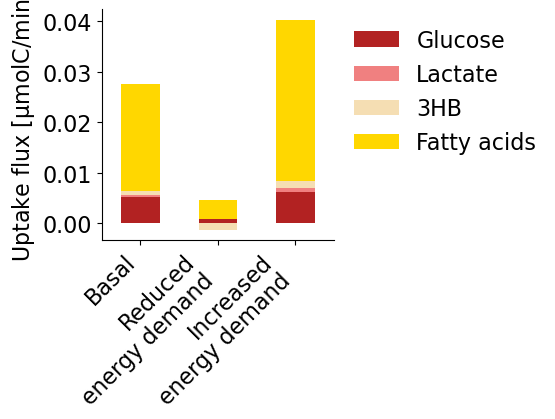

In [ ]:
# Energy demand

basal = compute_uptake_perturbation('hdca_e', 1)

additional_effect = {'vmax_forward_Stimulation_on': 0.1, }
reduced = compute_uptake_perturbation('hdca_e', 1, parameter_perturbation=additional_effect)


additional_effect = {'vmax_forward_Stimulation_on': 1.5, }
increased = compute_uptake_perturbation('hdca_e', 1.0, parameter_perturbation=additional_effect)


df = pd.DataFrame({'Basal':basal, 'Reduced\nenergy demand':reduced, 'Increased\nenergy demand':increased}).T

df.columns = ['Glucose',  'Lactate', '3HB', 'Fatty acids', ]
colors = colors_met

f, ax = plt.subplots(figsize=(3,3))
df.plot(kind='bar', stacked=True, color=colors, ax=ax, )
plt.xticks(rotation=45, ha='right')
plt.ylabel('Uptake flux [$\mathrm{\mu}$molC/min]')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
sns.despine()

plt.savefig('./output/energy_demand_perturbation.svg')


In [59]:
# Make a function to simulate pulsed atp demand
def compute_pulsed_response(atp_demand, T_on, T_off, cycles=50, additional_effect={}, initial_concentrations=None):

    # Compute the effective atp demand and print 
    atp_demand_effective = (atp_demand * T_on + T_off ) / (T_on + T_off)
    print(f'Effective atp demand increased by : {atp_demand_effective:.2f} ')

    res = []

    for i in range(cycles):

        # On pulse
        if i == 0:
            additional_effect_1 = {'vmax_forward_cyt_atp2adp':atp_demand}
            additional_effect_1.update(additional_effect)
            res_1 = compute_uptake_perturbation('hdca_e', 1.0, time=np.linspace(0,T_on),
                                        parameter_perturbation=additional_effect_1, steady_state=False, initial_concentrations=initial_concentrations)
        else: 
            additional_effect_1 = {'vmax_forward_cyt_atp2adp':atp_demand}
            additional_effect_1.update(additional_effect)
            res_1 = compute_uptake_perturbation('hdca_e', 1.0, time=np.linspace(0,T_on),
                                        parameter_perturbation=additional_effect_1, steady_state=False, 
                                        initial_concentrations=res_2.iloc[-1].to_dict())
        
        # Off pulse
        additional_effect_1 = {'vmax_forward_cyt_atp2adp':1}
        additional_effect_1.update(additional_effect)
        res_2 = compute_uptake_perturbation('hdca_e', 1.0, time=np.linspace(0,T_off),
                                      parameter_perturbation=additional_effect_1, steady_state=False, 
                                      initial_concentrations=res_1.iloc[-1].to_dict())
        
        # Adjust res_1 and res_2 for the time
        res_1.index = res_1.index + i * T_on + i * T_off
        res_2.index = res_2.index + (i + 1) * T_on + i * T_off


        res.append(res_1)
        res.append(res_2)

    return pd.concat(res, axis=0)

In [60]:
# res = compute_pulsed_response(20, 100/1000/60, 1/60/2, cycles=5000, initial_concentrations=mean_concentrations)

In [81]:
additional_effect = {'vmax_forward_Stimulation_on': 2.0,
                      #'o2_e': 10.0,
                      #'vmax_forward_MDHm': 10.0,
                      #'vmax_forward_NDPK1m': 10.0,
                      }

res = compute_uptake_perturbation('hdca_e', 1.0, time=np.linspace(0,10,1000),
                                  parameter_perturbation=additional_effect, 
                                  steady_state=False, 
                                  initial_concentrations=mean_concentrations)
cols = res.columns

In [82]:
def compute_vmax_backward(reaction):
    v_max_foward = reaction.parameters.vmax_forward.value
    k_eq = reaction.parameters.k_equilibrium.value
    stoich = reaction.reactant_stoichiometry

    kmfact = np.prod([p.value**-1 if 'substrate' in p.name else p.value**1 for p in reaction.parameters.values() if p.name.startswith('km_')])

    return v_max_foward / k_eq * kmfact


In [ ]:
# Get the relevant vmax depending on the reaction flux 
  
v_max = [compute_vmax_backward(r) * -1 if mean_fluxes.loc[r.name] < 0 else r.parameters.vmax_forward.value for r in kmodel.reactions.values()]

AttributeError: TabDict has no attribute or entry k_equilibrium

In [84]:
# Filter for reactions that ge close to vmax
vmax_min = 0.3
vmax_max = 5.0 # These are mass action 

rel_fluxes =(res.iloc[:,:len(kmodel.reactions)] / v_max)

# Filter out column
reactions_to_plot = [c for c in rel_fluxes.columns if all(rel_fluxes[c] < vmax_max) and any(rel_fluxes[c] > vmax_min)] 

#reactions_to_plot = [ r.id for r in tmodel.metabolites.get_by_id('pep_c').reactions]

# Plot the relative fluxes
f, ax = plt.subplots(figsize=(4,3))
rel_fluxes[reactions_to_plot].plot(ax=ax)

# legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

#plt.xlim([1e-1, 1e3]) 

NameError: name 'v_max' is not defined

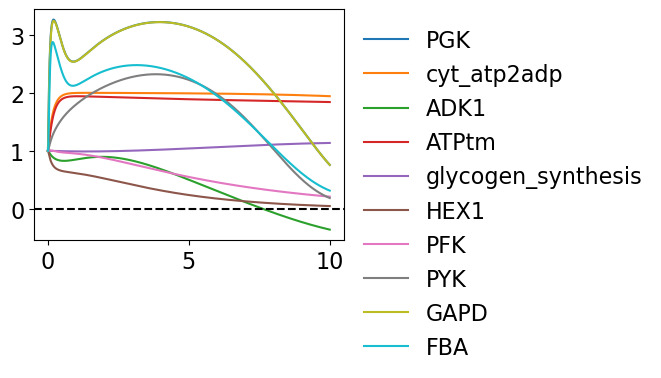

In [85]:
# Plot Glycerol shuttele fluxes 
f, ax = plt.subplots(figsize=(4,3))

reactions_to_plot = [ r.id for r in tmodel.metabolites.get_by_id('adp_c').reactions] + ['GAPD','FBA']

(res.iloc[:,:len(kmodel.reactions)]/mean_fluxes)[reactions_to_plot].plot(ax=ax)

# legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

#Horizaonctlline at 1
plt.axhline(0, color='k', linestyle='--')

#plt.xscale('log')
#plt.xlim([1e-1, 1e3])  



In [86]:
# All reactions with mitochondiral protons
for r in tmodel.reactions:
    if 'h_m' in [m.id for m in r.metabolites]:
        print(r.id, r.reaction)

ASPGLUm asp_L_m + glu_L_c + h_c --> asp_L_c + glu_L_m + h_m
BDHm bhb_m + nad_m --> acac_m + h_m + nadh_m
BHBtm bhb_c + h_c --> bhb_m + h_m
CSm accoa_m + h2o_m + oaa_m --> cit_m + coa_m + h_m
LDH_Lm lac_L_m + nad_m <-- h_m + nadh_m + pyr_m
L_LACtm h_c + lac_L_c <-- h_m + lac_L_m
MDHm mal_L_m + nad_m --> h_m + nadh_m + oaa_m
PYRt2m h_c + pyr_c --> h_m + pyr_m
FADH2ETC fadh2_m + q10_m --> fad_m + h_m + q10h2_m
ATPS4mi adp_m + 3.0 h_c + pi_m --> atp_m + h2o_m + 2.0 h_m
CYOR_u10mi 2.0 ficytC_m + 2.0 h_m + q10h2_m --> 2.0 focytC_m + 4.0 h_c + q10_m
NADH2_u10mi 5.0 h_m + nadh_m + q10_m --> 4.0 h_c + nad_m + q10h2_m
CYOOm2i 4.0 focytC_m + 8.0 h_m + o2_m --> 4.0 ficytC_m + 2.0 h2o_m + 4.0 h_c
PiC 2 h_c + pi_c --> 2 h_m + pi_m


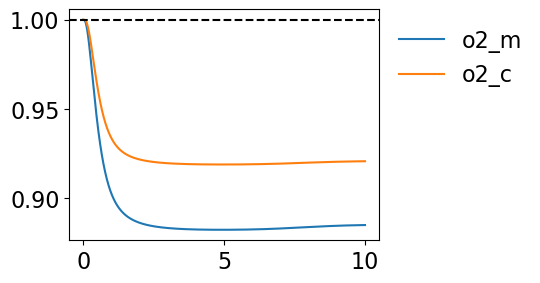

In [ ]:
# Plot relative concentrations of a set of metabolites
f, ax = plt.subplots(figsize=(4,3))

#metabolites_to_plot = [ 'g6p_c','f6p_c','fdp_c','dhap_c','g3p_c','atp_c','adp_c','nadh_c','pep_c','pyr_c']

metabolites_to_plot = ['o2_m','o2_c']

# Plot the relative concentrations
conc_filtered = res.iloc[:,len(kmodel.reactions):] / mean_concentrations
conc_filtered = conc_filtered[metabolites_to_plot]
conc_filtered.plot(ax=ax)

# legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
#plt.xscale('log')
#plt.xlim([1e-1, 1e3])  

# 
#plt.ylim([-1, 10])
# Horizaonctlline at 1
plt.axhline(1, color='k', linestyle='--')

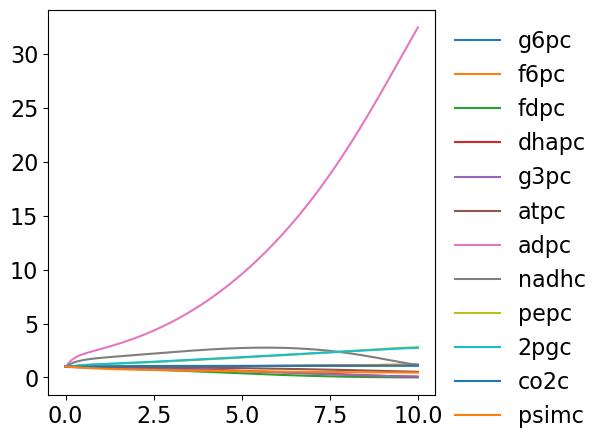

In [ ]:
# Plot relative concentrations 
conc = (res.iloc[:,len(kmodel.reactions):] / mean_concentrations).dropna(axis=1)

# maximum changein 10 min 
max_change = conc[conc.index  < 1e-1].abs().max() 
# Rank the metabolites by the maximum change
ranked_metabolites = list(max_change.sort_values(ascending=False).index)
# Get top 10
# conc_filtered = conc.loc[:,ranked_metabolites[:10] ] 
# conc_filtered = conc.loc[:,['h_c','h_m','nad_c','nad_c',
#                             'lac_L_c','pmtcoa_c','pyr_c','pyr_m','coa_m']]
conc_filtered = conc.loc[:,['g6p_c','f6p_c','fdp_c','dhap_c','g3p_c','atp_c','adp_c','nadh_c','pep_c',
                            '_2pg_c','co2_c','psi_m_c']]
# substitute metabolite names starting with _ 
conc_filtered.columns = [i.replace('_','') for i in conc_filtered.columns]
f, ax = plt.subplots(figsize=(5,5))
conc_filtered.plot(ax=ax)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
#plt.xscale('log')

#plt.ylim([0, 2])

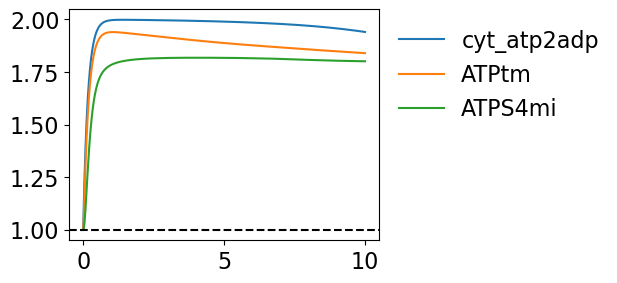

In [89]:
# Plot the ATP production fluxes  
f, ax = plt.subplots(figsize=(4,3))
reactions_to_plot =  ['cyt_atp2adp' , 'ATPtm', 'ATPS4mi', ]

# Compute running mean 

running_mean = (res.iloc[:,:len(kmodel.reactions)]/mean_fluxes)
running_mean[reactions_to_plot].plot(ax=ax)

# legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

#Horizaonctlline at 1
plt.axhline(1, color='k', linestyle='--')

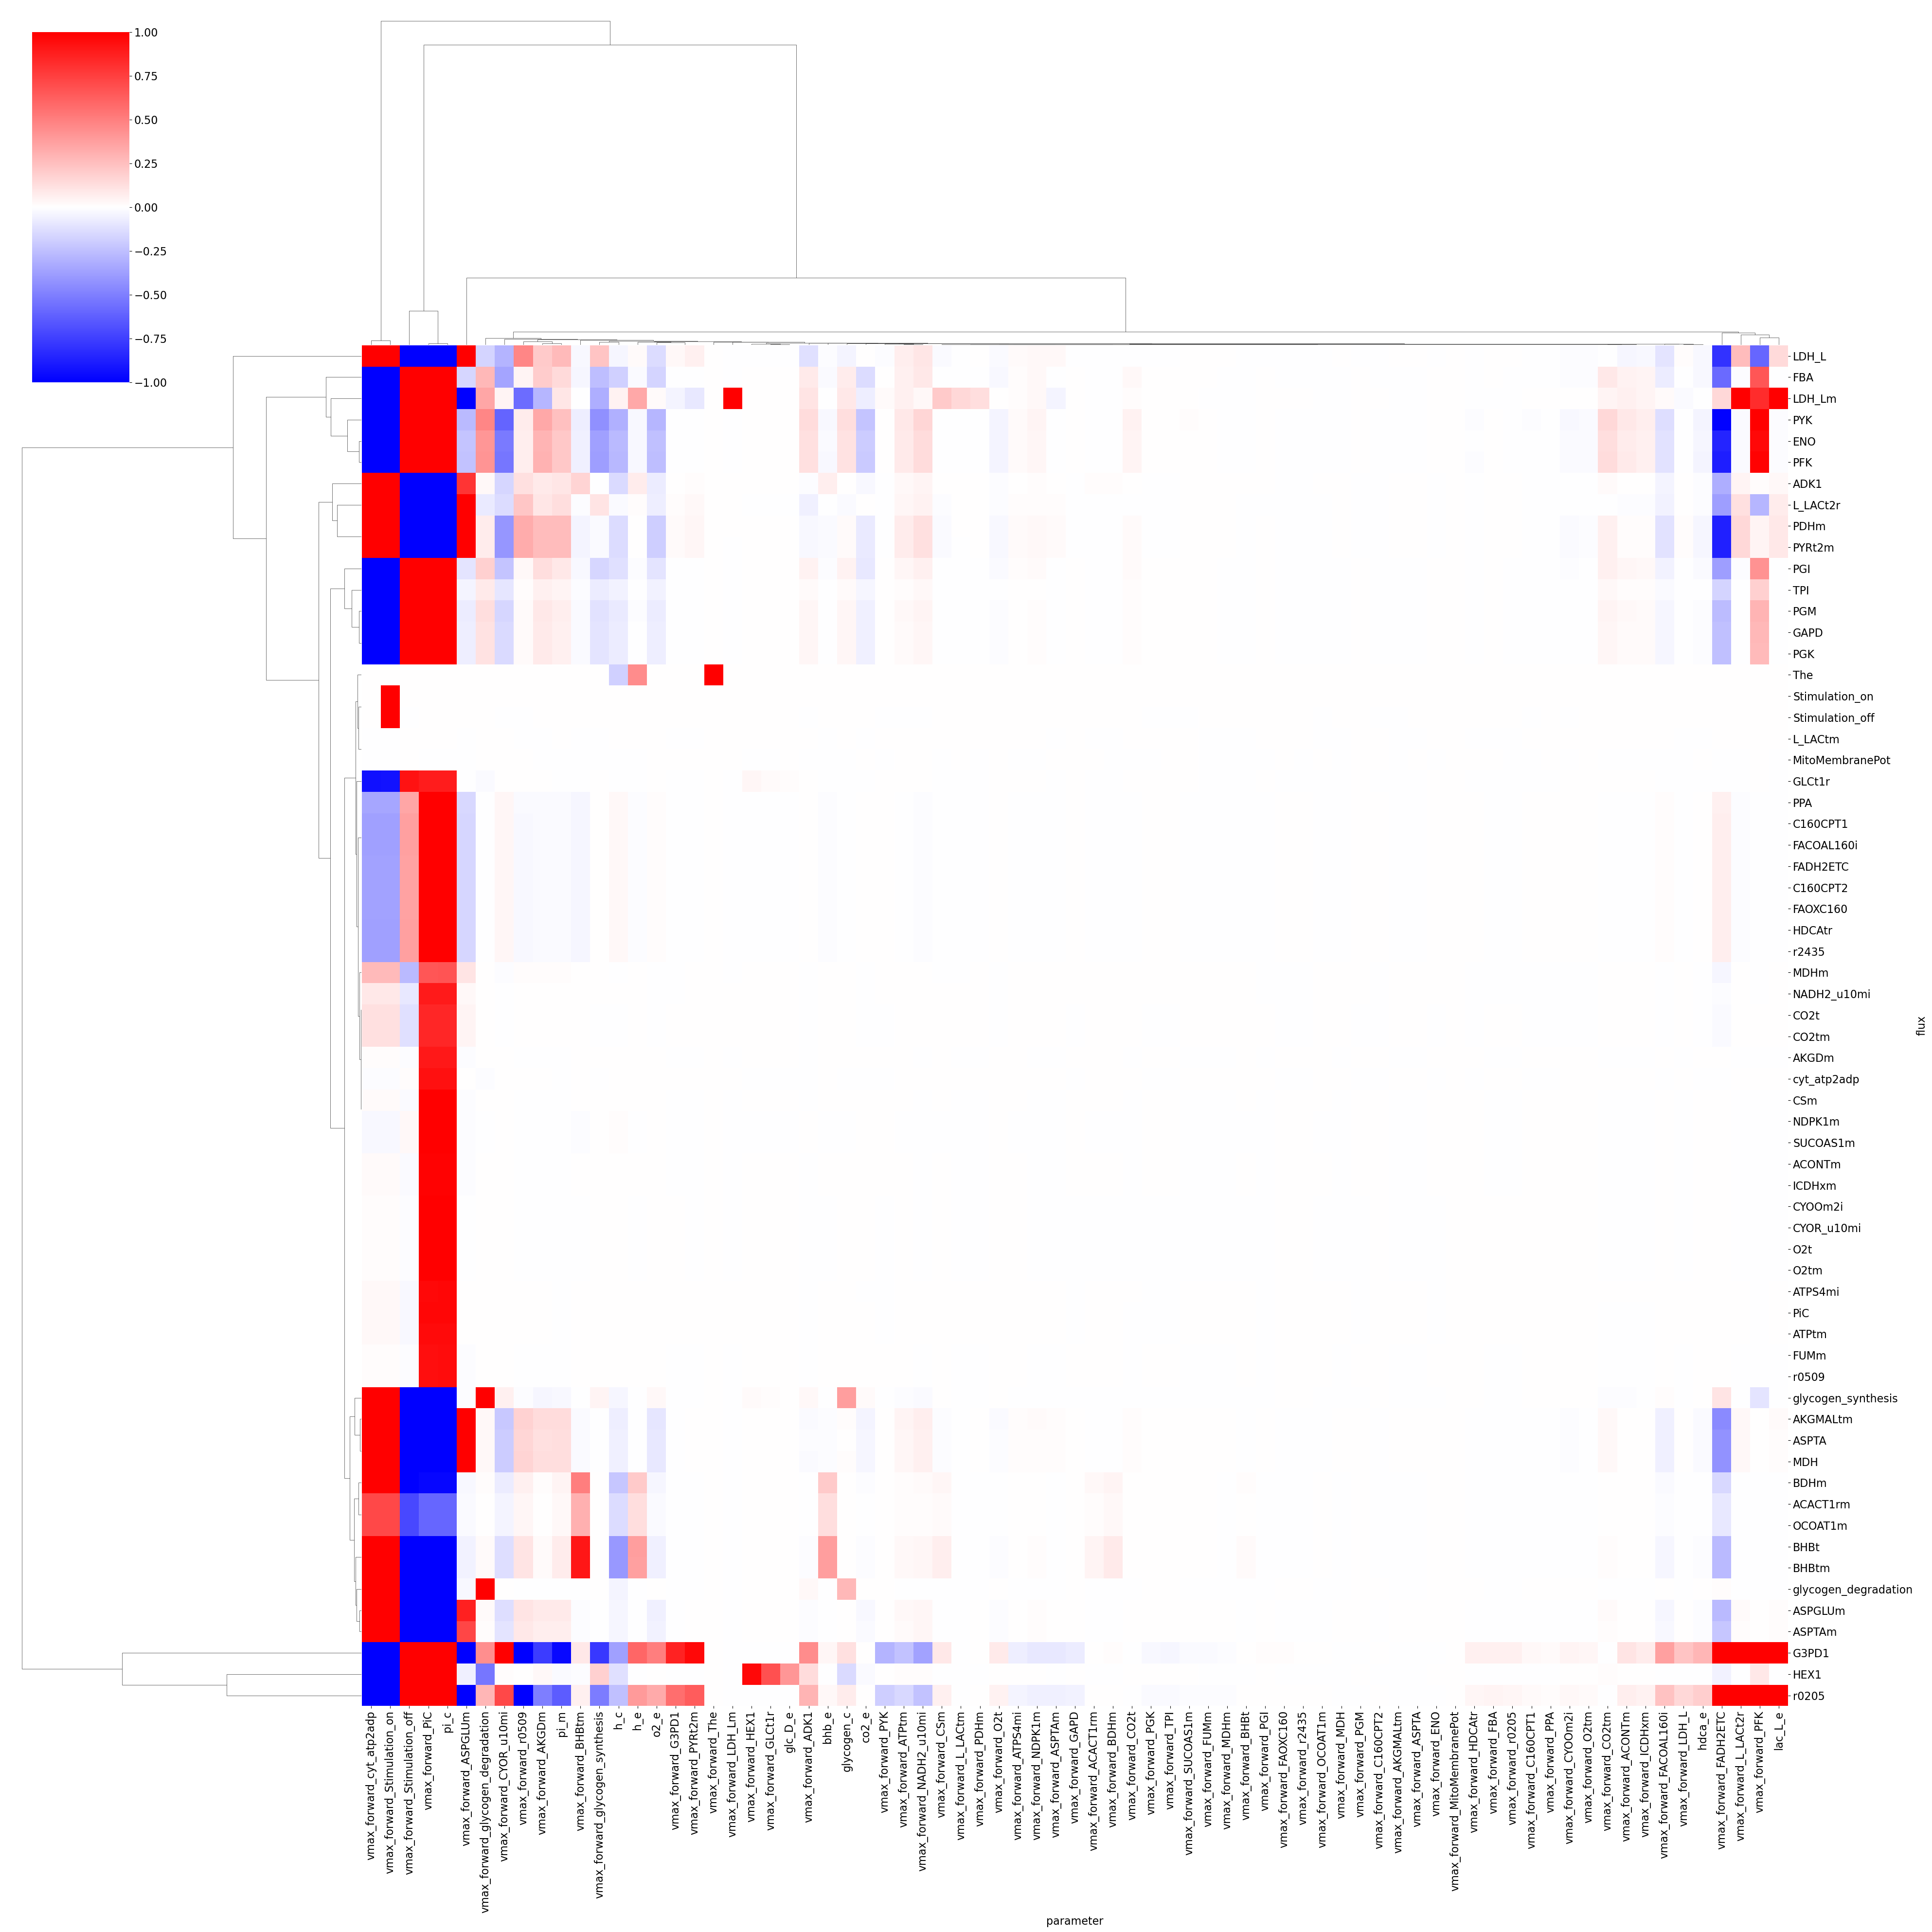

In [90]:
# Compute control coefficients after the perturbation

concentrations = res.iloc[-1,len(kmodel.reactions):]
fluxes = res.iloc[-1,:len(kmodel.reactions)]

parameter_values = parameter_population[closest_to_median]

control_coefficients_pert = kmodel.flux_control_fun(fluxes, concentrations, [parameter_values, ])
CC_P = control_coefficients_pert.slice_by('sample', 0)

# Plot the control coefficients as cluster map
sns.clustermap(CC_P,row_cluster=True,col_cluster=True, cmap='bwr', center=0, figsize=(40,40), vmin=-1, vmax=1)

In [149]:
kmodel.reactions.ADK1.mechanism.reaction_rates

TabDict([('v_net',
          -adp_c**2*h_c**(-1.0)*vmax_forward_ADK1/(k_equilibrium_ADK1*km_substrate1_ADK1*km_substrate2_ADK1*((adp_c/km_product1_ADK1 + atp_c/km_substrate1_ADK1)**1.0 + 1)*((adp_c/km_product2_ADK1 + amp_c/km_substrate2_ADK1)**1.0 + 1)) + amp_c*atp_c*vmax_forward_ADK1/(km_substrate1_ADK1*km_substrate2_ADK1*((adp_c/km_product1_ADK1 + atp_c/km_substrate1_ADK1)**1.0 + 1)*((adp_c/km_product2_ADK1 + amp_c/km_substrate2_ADK1)**1.0 + 1))),
         ('v_fwd',
          amp_c*atp_c*vmax_forward_ADK1/(km_substrate1_ADK1*km_substrate2_ADK1*((adp_c/km_product1_ADK1 + atp_c/km_substrate1_ADK1)**1.0 + 1)*((adp_c/km_product2_ADK1 + amp_c/km_substrate2_ADK1)**1.0 + 1))),
         ('v_bwd',
          adp_c**2*h_c**(-1.0)*vmax_forward_ADK1/(k_equilibrium_ADK1*km_substrate1_ADK1*km_substrate2_ADK1*((adp_c/km_product1_ADK1 + atp_c/km_substrate1_ADK1)**1.0 + 1)*((adp_c/km_product2_ADK1 + amp_c/km_substrate2_ADK1)**1.0 + 1)))])

In [54]:
# # Animate the fluxes on an ESCHER map to better understand the dynamics
# from skimpy.viz.escher import animate_fluxes

# this_chrome= "/Applications/Google\ Chrome.app/Contents/MacOS/Google\ Chrome"

# # Escher map 
# this_escher_map = "../data/Glycolysis-TCA-BetaOx-Ketones.json"

# reaction_scale = [
#     { 'type': 'value', 'value': 0, 'color': 'white', 'size': 12 },
#     { 'type':  'value', 'value': 1.0, 'color':'black', 'size': 32 }
#     ]

# res = compute_uptake_perturbation('hdca_e', 1.0, time=np.linspace(-3, 2, 60)-1e-3,
#                                   parameter_perturbation=additional_effect, steady_state=False, )

# # Make a video of the fluxes
# animate_fluxes(res.iloc[:,:len(kmodel.reactions)], this_escher_map, chrome=this_chrome, outputfile='./output/fluxes.mp4',
#                time_unit= 'min', reaction_scale=reaction_scale , time_interval_ms=200, docker=False)



In [ ]:
res

,ACACT1rm,ACONTm,ADK1,AKGDm,AKGMALtm,ASPGLUm,ASPTA,ASPTAm,ATPS4mi,ATPtm,...,lac_L_c,pyr_m,lac_L_m,gtp_m,gdp_m,o2_c,succ_m,f6p_c,_3pg_c,stim_e
0.000000,-0.004089,0.525522,0.047831,0.525522,0.095100,0.095100,0.095100,-0.095100,6.187573,6.709006,...,0.507778,0.079680,3.255293,0.075000,0.002732,1.402794,0.167088,0.133476,0.317331,1.000000
1.001001,-0.710494,1.573958,-1.333655,3.311391,-0.197617,0.122789,0.119982,-1.467564,36.612745,42.183363,...,0.593556,0.000004,3.070910,0.047175,0.030557,1.066379,0.009958,0.146514,0.440059,9.977825
2.002002,-0.716709,1.478950,-1.305421,1.697767,0.113815,0.140232,0.132087,-0.328536,22.371560,23.477003,...,0.613291,0.000001,2.823677,0.028746,0.048985,1.239968,0.002949,0.197092,0.486335,9.999945
3.003003,-0.718065,1.479096,-1.233731,1.494066,0.138130,0.142096,0.138907,-0.152987,20.377109,21.015045,...,0.594250,0.000001,2.630471,0.027138,0.050593,1.272762,0.002460,0.250520,0.503757,10.000000
4.004004,-0.722308,1.497058,-1.110290,1.500442,0.138445,0.142165,0.137748,-0.141995,20.378471,20.919428,...,0.572737,0.000002,2.478515,0.029889,0.047843,1.272931,0.002506,0.302950,0.518541,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995.995996,-0.743140,1.824854,0.007507,1.824853,0.140830,0.140832,0.140828,-0.140830,24.904025,25.985727,...,0.430594,0.000024,1.708906,0.047557,0.030174,1.220422,0.003899,40.262601,2.906385,10.000000
996.996997,-0.743140,1.824870,0.007507,1.824869,0.140830,0.140832,0.140827,-0.140830,24.904282,25.986000,...,0.430591,0.000024,1.708898,0.047558,0.030174,1.220419,0.003899,40.302123,2.906764,10.000000
997.997998,-0.743140,1.824885,0.007507,1.824885,0.140830,0.140832,0.140827,-0.140830,24.904538,25.986272,...,0.430589,0.000024,1.708890,0.047558,0.030174,1.220416,0.003899,40.341644,2.907142,10.000000
998.998999,-0.743140,1.824901,0.007507,1.824900,0.140830,0.140832,0.140827,-0.140830,24.904794,25.986543,...,0.430586,0.000024,1.708882,0.047558,0.030174,1.220413,0.003899,40.381164,2.907519,10.000000


In [ ]:
1/0

ZeroDivisionError: division by zero

In [ ]:
from skimpy.core.parameters import ParameterValues

# Compute a curve that captures the sensitivty of fasted fatty acids concentration to beta oxidation
ref_ffa = parameter_population[closest_to_median]['hdca_e']

ffa_conc = np.logspace(-1, 1, 100) * ref_ffa

uptakes = pd.Series({'GLCt1r':6, 'L_LACt2r':3, 'FATP1t':-16, 'BHBt':4 }, dtype=float)


kmodel.parameters = parameter_population[closest_to_median]

steady_state_fluxes_fasted = []

for ffa in ffa_conc:
    kmodel.parameters['hdca_e'].value = ffa
    sol = kmodel.solve_ode(np.linspace(0, 60, 100), solver_type='cvode' ,  max_steps=1e9,)
    # save the uptake fluxes
    parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
    parameter_values = ParameterValues(parameter_values, kmodel)
    this_fluxes = pd.Series(flux_fun(sol.concentrations.iloc[-1], parameters=parameter_values), index=kmodel.reactions.keys())
    this_fluxes = this_fluxes.loc[uptakes.keys()]

    steady_state_fluxes_fasted.append(this_fluxes)

steady_state_fluxes_fasted = pd.concat(steady_state_fluxes_fasted, axis=1).T
steady_state_fluxes_fasted[uptakes.keys()] = steady_state_fluxes_fasted[uptakes.keys()].multiply(uptakes, axis=1)




[CVODE ERROR]  CVode
  At t = 4.66441, the right-hand side routine failed in an unrecoverable manner.



SystemError: <method-wrapper '__getattribute__' of EnumMeta object at 0x7fa5fe8d02c0> returned a result with an error set

In [ ]:
# Compute a fed state perturbation 
kmodel.parameters = parameter_population[closest_to_median]

# Concentrations 
#kmodel.parameters['glc_D_e'].value = 7.5    # concentration in mM
#kmodel.parameters['lac_L_e'].value = 0.75    # concentration in mM Guess
#kmodel.parameters['hdca_e'].value = 0.2  # concentration in mM
#kmodel.parameters['bhb_e'].value = 0.1    # concentration in mM

# Insulin effect on glucose transport
#kmodel.parameters['vmax_forward_GLCt1r'].value = parameter_population[closest_to_median]['vmax_forward_GLCt1r'] * 10.0
#kmodel.parameters['vmax_forward_PFK'].value = parameter_population[closest_to_median]['vmax_forward_PFK'] * 10.0

# This is hypothetical 
#kmodel.parameters['vmax_forward_C160CPT2'].value = parameter_population[closest_to_median]['vmax_forward_C160CPT2'] * 0.5

In [ ]:
# Solve the ODE system to find the new steady-state
time = np.linspace(0,60, 500)
sol_fed = kmodel.solve_ode(time,solver_type='cvode')

Text(0, 0.5, 'Flux (mmolC/L/h)')

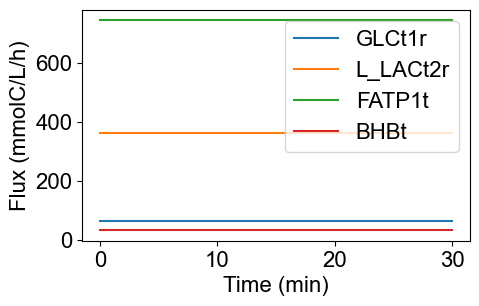

In [ ]:
from skimpy.core.parameters import ParameterValues
parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
parameter_values = ParameterValues(parameter_values, kmodel)

fluxes = pd.Series( flux_fun(concentrations=concentrations, parameters=parameter_population[closest_to_median]), index=kmodel.reactions.keys())

sol_fed_fluxes = pd.DataFrame( [ flux_fun(sol_fed.concentrations.loc[i], parameters=parameter_values) for i in  sol_fed.concentrations.index] , index=sol_fed.concentrations.index, columns=kmodel.reactions.keys())


time = sol_fed.time
sol_fed_fluxes_temp = sol_fed_fluxes.copy()
sol_fed_fluxes_temp['time'] = time  * 60
sol_fed_fluxes_temp[uptakes.keys()] = sol_fed_fluxes_temp[uptakes.keys()].multiply(uptakes, axis=1)
sol_fed_fluxes_temp.plot(x='time', y=uptakes.keys(), figsize=(5,3))

plt.xlabel('Time (min)')
plt.ylabel('Flux (mmolC/L/h)')

In [ ]:
# # # Explore regulation of what is likely to regulate energy demand by looking most sensitive metabolties to reduction of ATP demand
# kmodel.parameters = parameter_population[closest_to_median]

# # Change cyt_atp2adp incrase 2 fold  // this does not work
# kmodel.parameters['vmax_forward_cyt_atp2adp'].value = parameter_population[closest_to_median]['vmax_forward_cyt_atp2adp'] * 2.0
# #kmodel.parameters['vmax_forward_GLCt1r'].value = parameter_population[closest_to_median]['vmax_forward_GLCt1r'] * 10.0


In [ ]:
# Initial conditions
for k in kmodel.initial_conditions:
        kmodel.initial_conditions[k] = sol_fed.concentrations.iloc[-1][k]

In [ ]:
steady_state_fluxes_fed = []

for ffa in ffa_conc:
    kmodel.parameters['hdca_e'].value = ffa
    sol = kmodel.solve_ode(np.linspace(0, 60, 100), solver_type='cvode' ,  max_steps=1e9,)
    # save the uptake fluxes
    parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
    parameter_values = ParameterValues(parameter_values, kmodel)
    this_fluxes = pd.Series(flux_fun(sol.concentrations.iloc[-1], parameters=parameter_values), index=kmodel.reactions.keys())
    this_fluxes = this_fluxes.loc[uptakes.keys()]

    steady_state_fluxes_fed.append(this_fluxes)

steady_state_fluxes_fed = pd.concat(steady_state_fluxes_fed, axis=1).T
steady_state_fluxes_fed[uptakes.keys()] = steady_state_fluxes_fed[uptakes.keys()].multiply(uptakes, axis=1)

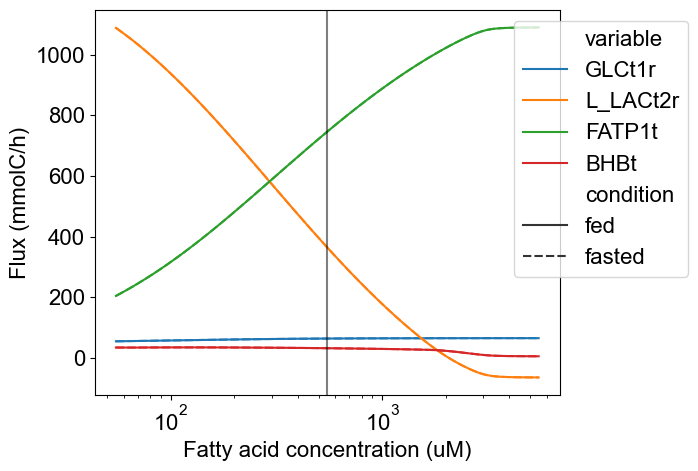

In [ ]:
steady_state_fluxes_fed['condition'] = 'fed'
steady_state_fluxes_fed['ffa'] = ffa_conc * 1e3 # Concentration in uM
steady_state_fluxes_fasted['condition'] = 'fasted'
steady_state_fluxes_fasted['ffa'] = ffa_conc * 1e3 # Concentration in uM

steady_state_fluxes = pd.concat([steady_state_fluxes_fed, steady_state_fluxes_fasted])

import seaborn as sns

steady_state_fluxes_db = steady_state_fluxes.melt(id_vars=['condition', 'ffa'], value_vars=['GLCt1r', 'L_LACt2r', 'FATP1t', 'BHBt'])
# Plot the uptake fluxes as a function of the fatty acid concentration
f, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(data=steady_state_fluxes_db, x='ffa', y='value', hue='variable', style='condition', ax =ax)
plt.xscale('log')
plt.xlabel('Fatty acid concentration (uM)')
plt.ylabel('Flux (mmolC/h)')

# Vertical line at ref_ffa
plt.axvline(ref_ffa * 1e3, color='k', linestyle='-', alpha =0.5)

# Legend outside the plot on the top right
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))


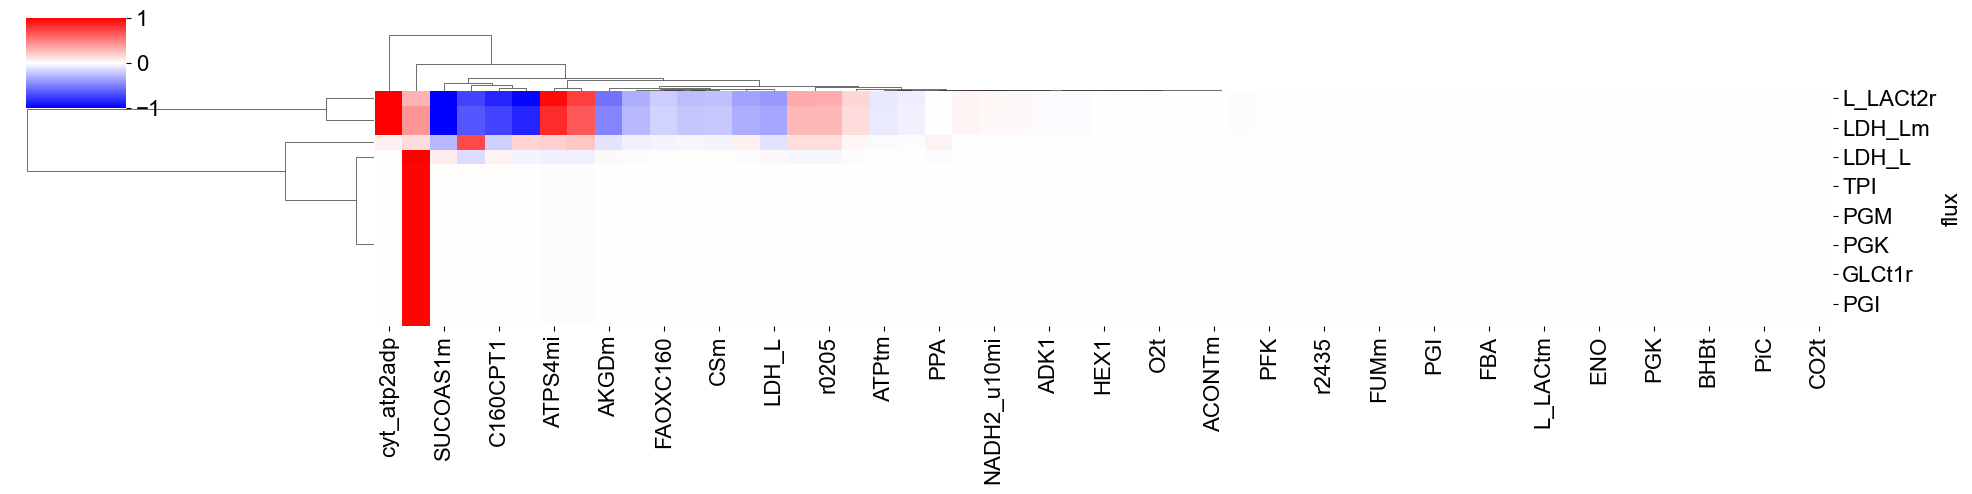

In [ ]:
glucose_resp = [ 'GLCt1r','HEX1', 'PGI', 'PFK', 'FBA', 'TPI', 'GAPD', 'PGK', 'PGM', 'ENO', 'PYK', 'PYRt2m', 'LDH_L',]
lactate_resp = [ 'L_LACt2r','L_LACtm', 'LDH_Lm', ]

lac_glu_rows = glucose_resp + lactate_resp
# Control coefficients in the new steady state
test_fc = kmodel.flux_control_fun(sol_fed_fluxes.iloc[-1],sol.concentrations.iloc[-1],[parameter_values, ]).slice_by('sample', 0)
test_fc.columns = [i.replace("vmax_forward_", '') for i in test_fc.columns ]
sns.clustermap(test_fc.loc[lac_glu_rows,colums], row_cluster=True, col_cluster=True, cmap='bwr', center=0, figsize=(20,5) , vmin=-1, vmax=1)

In [ ]:
# # Control coefficients in the new steady state
# test_cc = kmodel.concentration_control_fun(sol_fluxes.iloc[-1],sol.concentrations.iloc[-1],[parameter_values, ]).slice_by('sample', 0)
# sns.clustermap(test_cc, row_cluster=True, col_cluster=True, cmap='bwr', center=0, figsize=(20,20), vmin=-1, vmax=1)    

/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


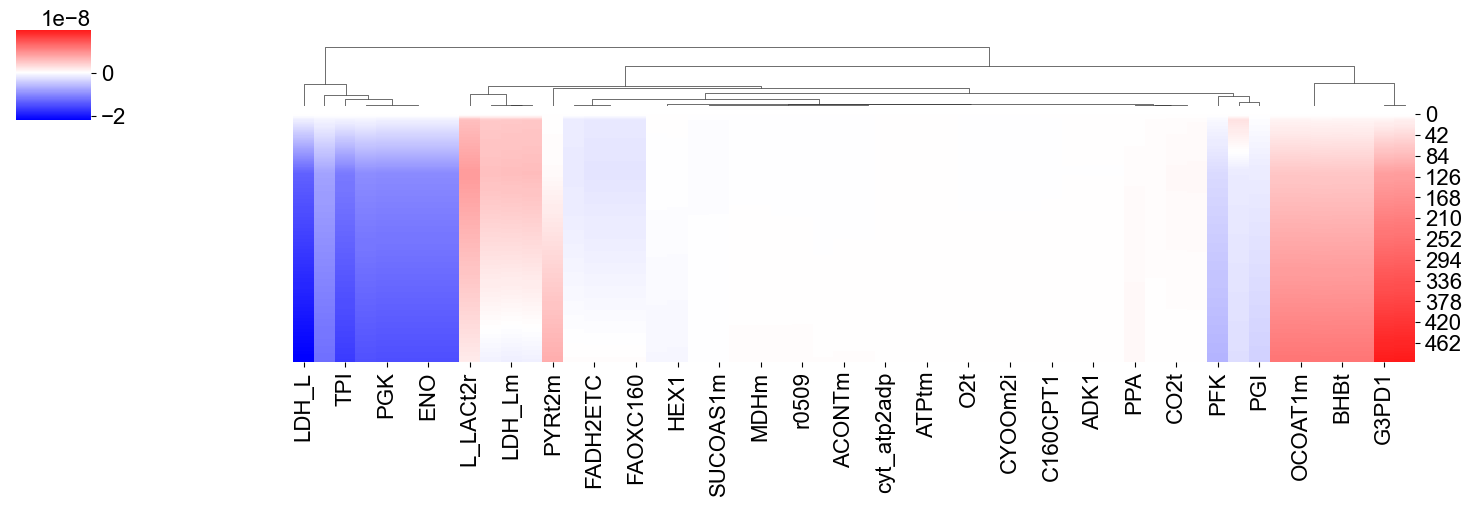

In [ ]:
# Convert the time series concentration in to a logic series of which elements start rising and which start falling in which order
fluxes_fold_change = np.log2(sol_fed_fluxes.div(fluxes, axis=1))
fluxes_fold_change = fluxes_fold_change.dropna(axis=1)

# Make a cluster map 
sns.clustermap(fluxes_fold_change, row_cluster=False, col_cluster=True, cmap='bwr', center=0, figsize=(15,5))
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


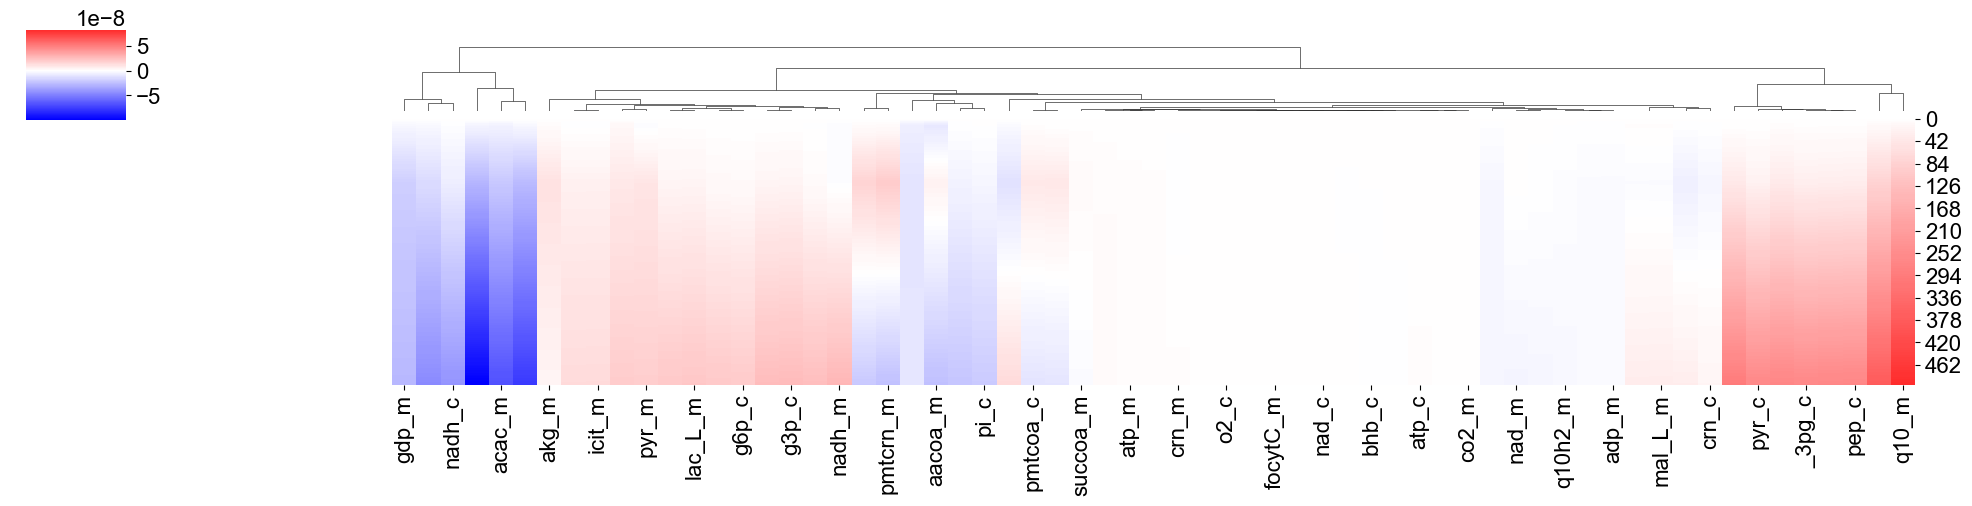

In [ ]:
# Convert the time series concen
concentrations_fold_change = np.log2(sol_fed.concentrations.div(concentrations, axis=1))
concentrations_fold_change = concentrations_fold_change.dropna(axis=1)

# Make a cluster map 
sns.clustermap(concentrations_fold_change, row_cluster=False, col_cluster=True, cmap='bwr', center=0, figsize=(20,5))
plt.show()

Text(0.5, 0, 'Time (min)')

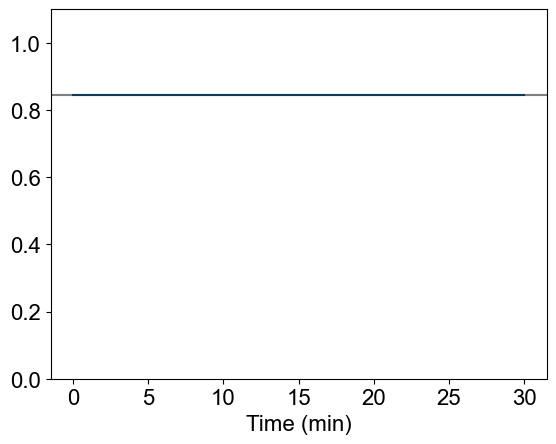

In [ ]:
# Compute complex I displacement (NADH2_u10mi)
k_eq = kmodel.reactions.NADH2_u10mi.parameters.k_equilibrium.value

gamma_complex_I = sol_fed.concentrations['q10h2_m'] * sol_fed.concentrations['nad_m'] * sol_fed.concentrations['h_c']**4 / ( sol_fed.concentrations['nadh_m'] * sol_fed.concentrations['q10_m'] * sol_fed.concentrations['h_m']**6) / k_eq 

gamma_complex_I_ref = concentrations['q10h2_m'] * concentrations['nad_m'] * concentrations['h_c']**4 / ( concentrations['nadh_m'] * concentrations['q10_m'] * concentrations['h_m']**6) / k_eq

plt.plot(sol_fed.time * 60, gamma_complex_I)

# Plot horizontal line at the reference value
plt.axhline(gamma_complex_I_ref, color='k', linestyle='-', alpha =0.5)
plt.ylim(0,1.1)
plt.xlabel('Time (min)')

In [ ]:
def metabolite_balance(met_id, data, tmodel):
    met = tmodel.metabolites.get_by_id(met_id)
    reactions = met.reactions

    # Find reaction that change direction
    changing_reactions = []
    for r in reactions:
        fluxes = data.loc[:,r.id]
        if fluxes.min() * fluxes.max() < 0:
            changing_reactions.append(r.id)
    
    ref_fluxes = data.loc[0,[r.id for r in reactions]]
    
    consumption =dict()
    production = dict()
    # Find reactions that are only producing or consuming the metabolite
    for r in reactions:
        stoich = r.metabolites[met]  
        if ref_fluxes[r.id] * stoich < 0 and not r.id in changing_reactions:
            consumption[r.id] = -stoich
        elif ref_fluxes[r.id] * stoich > 0 and not r.id in changing_reactions:
            production[r.id] = stoich
    
    production = pd.Series(production, dtype=float)
    consumption = pd.Series(consumption, dtype=float)
    
    # Build da results table
    production_fluxes = data.loc[:,production.keys()].multiply(production,axis=1).sum(axis=1)
    consumption_fluxes = data.loc[:,consumption.keys()].multiply(consumption,axis=1).sum(axis=1)

    fluxes = data.loc[:,changing_reactions]
    fluxes[f'{met_id} production'] = production_fluxes
    fluxes[f'{met_id} consumption'] = consumption_fluxes    

    return fluxes



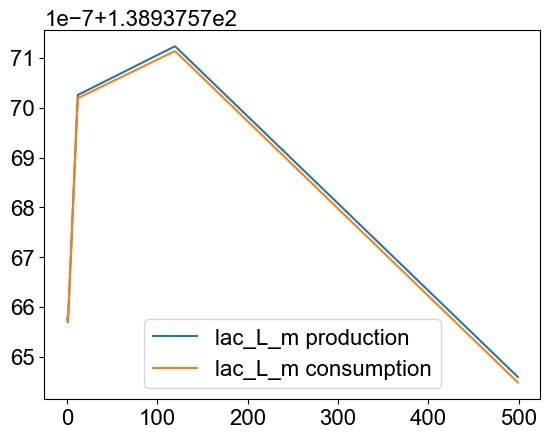

In [ ]:
balance = metabolite_balance('lac_L_m', sol_fed_fluxes, tmodel)
balance.plot()
plt.show()

Text(0, 0.5, '')

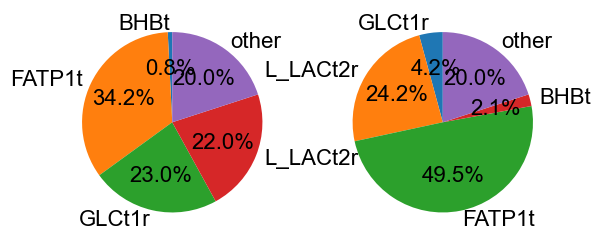

In [ ]:
# ANOTHER STORY

# To test how close to zero the dxdt is
flux_scaling_factor = 1e-3 / (GDW_GWW_RATIO / DENSITY) \
                        * CONCENTRATION_SCALING \
                        / TIME_SCALING

fluxes_profiles = pd.read_csv('reduced_model_ETC_core_20240710-100629_char_flux_profiles.csv', index_col=0)
# Convert from tfa to kintic flux spapce 
fluxes_profiles = fluxes_profiles * flux_scaling_factor

reaction_ix = list(kmodel.reactions.keys())


# Compute the mean carbon flux from fed fed state predition 
mean_carbon_flux_fed = fluxes_profiles.loc[:,'fed'].loc[rows].abs() * carbons

# Drop the cytosolic ATP/ADP exchange
mean_carbon_flux_fed = mean_carbon_flux_fed.drop('cyt_atp2adp', axis=0)

# Add a column that accounts for 25% of the total flux and label it as 'other'
mean_carbon_flux_fed['other'] = mean_carbon_flux_fed.sum() * (1/0.80 - 1)


# A pie chart shoeing the distribution of the mean carbon flux:
fig, ax = plt.subplots(1,2)
mean_carbon_flux_fed.plot.pie(ax=ax[0], subplots=True, figsize=(5,5), autopct='%1.1f%%', startangle=90)
mean_carbon_flux.plot.pie(ax=ax[1], subplots=True, figsize=(5,5), autopct='%1.1f%%', startangle=90)
plt.ylabel('')


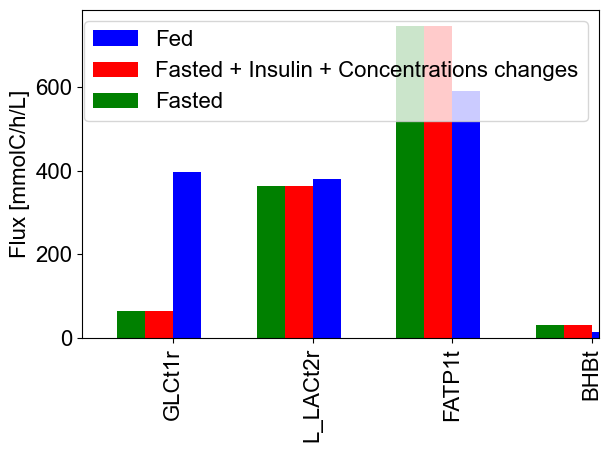

In [ ]:
# Compare uptake fluxes between simulated and inferred
uptakes = pd.Series({'GLCt1r':6, 'L_LACt2r':3, 'FATP1t':-16, 'BHBt':4 }, dtype=float)
# Plot target and predicted fluxes as stacked bars next to each other
fig, ax = plt.subplots(1,1)

target_fluxes = fluxes_profiles.loc[uptakes.keys(),'fed'].multiply(uptakes, axis=0)
predicted_fluxes = sol_fed_fluxes[uptakes.keys()].iloc[-1].multiply(uptakes, axis=0)
original_fluxes = fluxes_profiles.loc[uptakes.keys(),'fasted'].multiply(uptakes, axis=0)

target_fluxes.plot(kind='bar', ax=ax, color='b', position=0, width=0.2, label='Fed')
predicted_fluxes.plot(kind='bar', ax=ax, color='r', position=1, width=0.2, label='Fasted + Insulin + Concentrations changes')
original_fluxes.plot(kind='bar', ax=ax, color='g', position=2, width=0.2, label='Fasted')

plt.ylabel('Flux [mmolC/h/L]')
plt.legend()
plt.tight_layout()
plt.show()